<a href="https://colab.research.google.com/github/katrinakis/pds-a2-food-hazard-detection/blob/main/A2.2.colab.version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

**Course**: Practical Data Science - MSc in Data Science

**Title**: A2 Assignment - SemEval Food Hazard Detection Challenge

**Student**: Christos Katrinakis

**Student id**: f3352316

## Description
1. Participate in the [Food Hazard Detection Challenge](https://food-hazard-detection-semeval-2025.github.io/) by downloading and exploring the data.
2. Perform two benchmark analyses using both basic and advanced ML algorithms, and evaluate your experimental results.
    - One benchmark should focus on the **short texts** (titles) provided
    - and the other on the **long texts**.

4. Based on your findings, determine the best-performing system, and submit your predictions along with the score and rank received on the leaderboard.

Your solution should be hosted in a GitHub repository, which must include:
- A README file detailing your results and other important information.
- All code files required to run your solution, and making it easy to re-run by following the provided guidelines in the README.

Submit the link to your GitHub project. Ensure that version control is used throughout your work, allowing us to review your progress.

<h2 style="color:#B5E853">SemEval 2025 Task 9: The Food Hazard Detection Challenge</h2>


* The Food Hazard Detection task evaluates <span style="color:#B5E853">**explainable classification systems**</span> for <span style="color:#B5E853">**titles**</span> of <span style="color:#B5E853">**food-incident reports**</span> collected <span style="color:#B5E853">**from the web**</span>.
* These algorithms may help automated crawlers find and extract food issues from web sources like social media in the future.
* Due to the potential high economic impact, <span style="color:#B5E853">**transparency is crucial**</span> for this task.

The SemEval-Task combines two sub-tasks:

>(ST1) Text classification for food hazard prediction, predicting the type of hazard and product.

>(ST2) Food hazard and product “vector” detection, predicting the exact hazard and product.

The task focuses on detecting the hazard and uses a two-step scoring metric based on the macro F1 score, focusing on the hazard feature per sub-task.

<img src="https://github.com/katrinakis/pds-a2-food-hazard-detection/blob/main/data/overview.png?raw=1" alt="overview" height="550"/>

Figure: *The blue boxes are model inputs; the orange boxes are ground truth features per sub-task. The number on the right indicates unique values per feature.*

## Data

In [ ]:
# download training data (labeled):
# !curl https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_train.csv

import pandas as pd
incidents = pd.read_csv("data/incidents_train.csv", index_col=0) # Read training data
incidents.sample()

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
4838,2021,2,26,ie,Salmonella in chicken by SFC from United Kingdom,Recall of a Batch of SFC Chicken Poppets Due t...,biological,"meat, egg and dairy products",salmonella,chicken


### Description

The data consists of 10 columns:

**Features**
- ***title***: Short text. The title of a food incident report, collected from the internet
- ***text***: Long text. The text contents of the recall.

**Labels**
- ***hazard-category*** (ST1)
- ***product-category*** (ST1)
- ***hazard*** (ST2)
- ***product*** (ST2)



## Preprocessing (unused)

[skip section](##setup)

* Preprocessing could perhaps help improve the quality of the vectorization, especially through lemmatization, and enhance the performance of the classifiers.
* Experiments conducted with the lemmatized version of the `title` feature did not show any improvement (for various combinations of SVM parameters and scaling, with n-gram range -stupidely- set to (2,5) at the time).
* To the contrary they showed a slight decrease, consistent across all experiments.
* **Conclusion**: We decide to not use any preprocessing on the data. *I leave this section in as a learning reference, transparency and posterity.*

If you want to use the lemmatized text and don't want to rerun the process, skip to the last cell of this section.

In [ ]:
# Code adapted from https://github.com/codebasics/nlp-tutorials

# utility function for pre-processing the text
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)

* We did not lowercase because the `TfidfVectorizer` has *`lowercasebool, default=True`*, which
converts all characters to lowercase before tokenizing.
* Stopword removal and lemmatization are general processes and do not leak the test set into the training set. We therefore do not need to include them in the pipeline.

In [ ]:
# Apply preprocessing to titles
incidents['preprocessed_title'] = incidents['title'].apply(preprocess)

# Apply preprocessing to texts
incidents['preprocessed_text'] = incidents['text'].apply(preprocess)

# Save the DataFrame to a CSV file
incidents.to_csv("data/preprocessed_data.csv", index=False)

If one wants to use the lemmatized text, start from here.

In [ ]:
import pandas as pd
incidents = pd.read_csv("data/preprocessed_data.csv")
incidents.rename(columns={"preprocessed_title":"lt-title", 'preprocessed_text': 'lt-text'}, inplace=True)
incidents.head(3)

,year,month,day,country,title,text,hazard-category,product-category,hazard,product,lt-title,lt-text
0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage,Recall Notification fsis-024 94,case number 024 94 \n Date open ...
1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage,Recall Notification FSIS-033 94,case number 033 94 \n Date open ...
2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices,Recall Notification fsis-014 94,case number 014 94 \n Date open ...


## Setup

We wrap this routine in function code so we don't have to copy-paste every time.

We will use this to try various classifiers and measure their performance

In [ ]:
from functools import singledispatch
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

@singledispatch
def experiment(arg):
    raise TypeError(f"Unsupported type: {type(arg)}")

@experiment.register
def _(classifier: BaseEstimator, feature: str = 'title'):
    """Takes classifier as input, not the whole pipeline
    Runs the experiment across labels and stores metrics.
    Performs 5-fold Monte Carlo Cross Validation."""
    text_clf = Pipeline([
        ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1, 1), max_df=0.5, min_df=1)),
        ('scaler', None),
        ('clf', classifier)
    ])
    if feature == 'text':
        text_clf = Pipeline([
            ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='word', max_features=6000)),
            ('scaler', None),
            ('clf', classifier)
        ])

    # Metrics storage
    results = {
        'f1_scores': {label: [] for label in ('hazard-category', 'product-category', 'hazard', 'product')},
        'reports': {label: [] for label in ('hazard-category', 'product-category', 'hazard', 'product')},
        'cms': {label: [] for label in ('hazard-category', 'product-category', 'hazard', 'product')}
    }

    # 5-fold Monte Carlo Cross Validation
    for i in range(5):
        print("-" * 20)
        print(f"FOLD {i+1}\n" + "-" * 20)
        train, dev = train_test_split(incidents, test_size=0.2, random_state=2024 + i)

        for label in ('hazard-category', 'product-category', 'hazard', 'product'):
            # Classify and collect metrics
            macro_f1, micro_f1, report, cm = classify_target(
                target_variable=label,
                feature=feature,
                text_clf=text_clf,
                train=train,
                dev=dev
            )
            # Store metrics
            results['f1_scores'][label].append(macro_f1)
            results['reports'][label].append(report)
            results['cms'][label].append(cm)

    return results, text_clf.named_steps['vect'].get_feature_names_out()

@experiment.register
def _(pipeline: Pipeline, feature: str = 'title'):
    """Takes the whole pipeline as input.
    Runs the experiment across labels and stores metrics.
    Performs 5-fold Monte Carlo Cross Validation."""
    text_clf = pipeline

    # Metrics storage
    results = {
        'f1_scores': {label: [] for label in ('hazard-category', 'product-category', 'hazard', 'product')},
        'reports': {label: [] for label in ('hazard-category', 'product-category', 'hazard', 'product')},
        'cms': {label: [] for label in ('hazard-category', 'product-category', 'hazard', 'product')}
    }

    # 5-fold Monte Carlo Cross Validation
    for i in range(5):
        print("-" * 20)
        print(f"FOLD {i+1}\n" + "-" * 20)
        train, dev = train_test_split(incidents, test_size=0.2, random_state=2024 + i)

        for label in ('hazard-category', 'product-category', 'hazard', 'product'):
            # Classify and collect metrics
            macro_f1, micro_f1, report, cm = classify_target(
                target_variable=label,
                feature=feature,
                text_clf=text_clf,
                train=train,
                dev=dev
            )
            # Store metrics
            results['f1_scores'][label].append(macro_f1)
            results['reports'][label].append(report)
            results['cms'][label].append(cm)

    return results, text_clf.named_steps['vect'].get_feature_names_out()

def classify_target(target_variable: str, feature: str, text_clf: Pipeline, train: pd.DataFrame, dev: pd.DataFrame):
    """Helper function for classification and evaluation."""
    # Train the model
    text_clf.fit(train[feature], train[target_variable])

    # Predict for the dev set
    dev['predictions-' + target_variable] = text_clf.predict(dev[feature])

    # Compute metrics
    macro_f1 = f1_score(dev[target_variable], dev['predictions-' + target_variable], zero_division=0, average="macro")
    micro_f1 = f1_score(dev[target_variable], dev['predictions-' + target_variable], zero_division=0, average="micro")
    report = classification_report(dev[target_variable], dev['predictions-' + target_variable], zero_division=0, output_dict=True)
    cm = confusion_matrix(dev[target_variable], dev['predictions-' + target_variable])

    print(f"Target: {target_variable.upper()} | Macro F1: {macro_f1:.2f} | Micro F1: {micro_f1:.2f}")

    return macro_f1, micro_f1, report, cm


We also need a way to review the results of the cross validation:

In [ ]:
def print_cv_scores(cv_scores: dict):
    """Gives the cross validated mean and standard error of some score.
    """
    scores_pd = pd.DataFrame(cv_scores)
    return scores_pd.agg(['mean', 'sem']).round(4)


and also visualize them if possible:

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_cv_scores(cv_scores: dict):
    """Visualizes cross-validated mean scores and standard errors."""

    # Convert cv_scores dictionary to a DataFrame
    scores_df = pd.DataFrame(cv_scores)

    # Aggregate mean and standard error
    summary_stats = scores_df.agg(['mean', 'sem'])

    # Extract data for plotting
    labels = summary_stats.columns
    means = summary_stats.loc['mean']
    errors = summary_stats.loc['sem']

    # Define custom colors for the bars
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Four distinct colors

    # Plot bar chart with error bars
    plt.figure()
    bar_width = 0.5  # Reduce bar width
    bars = plt.bar(labels, means, yerr=errors, capsize=5, alpha=0.9, color=colors, width=bar_width, edgecolor='black')

    # Add numeric labels above bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{yval:.2f}", ha='center', fontsize=10)

    # Customize chart appearance
    plt.ylabel('F1 Score', fontsize=12)
    plt.title('Cross-Validated F1 Scores with Standard Errors', fontsize=14)
    plt.ylim(0, 1)  # F1-scores range from 0 to 1
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

And a way to aggregate over classification reports from multiple folds:

**Explanation**:
- *Precision, Recall, F1-Score*: These are averaged across folds for each class.
- *Support*: This is summed across folds for each class.
- *Macro and Weighted Averages*: These are aggregated similarly to individual classes.

This approach ensures all metrics are cleanly aggregated and ready for further analysis or reporting.

In [ ]:
from collections import defaultdict
import numpy as np

def print_cr(classification_reports: dict, label: str):
    # Aggregate crs
    aggregated_reports = aggregate_nested_classification_reports(classification_reports)
    # Access the aggregated report for label
    label_report = aggregated_reports[label]
    # Return
    return pd.DataFrame(label_report).transpose().astype({'support':'int'}).round(2)

def aggregate_nested_classification_reports(reports_dict):
    """
    Aggregates nested classification reports from multiple folds.

    Args:
        reports_dict (dict): A dictionary where each key is a label and values are lists of reports for each fold.

    Returns:
        dict: Aggregated classification report for each label.
    """
    aggregated_reports = {}

    for label, reports in reports_dict.items():
        # Initialize storage for metrics
        aggregated_metrics = defaultdict(lambda: defaultdict(list))

        # Collect metrics across folds
        for fold_report in reports:
            for class_name, metrics in fold_report.items():
                if isinstance(metrics, dict):  # Skip overall metrics like 'accuracy'
                    for metric_name, value in metrics.items():
                        aggregated_metrics[class_name][metric_name].append(value)

        # Compute averages and sums for metrics
        aggregated_label_report = {}
        for class_name, metrics in aggregated_metrics.items():
            aggregated_label_report[class_name] = {
                metric_name: (np.sum(values) if metric_name == "support" else np.mean(values))
                for metric_name, values in metrics.items()
            }

        aggregated_reports[label] = aggregated_label_report

    return aggregated_reports

## Title Classification

### Majority classifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

# We are using titles to classify
feature = 'title'

# Get scores for each label
macro_f1_majority_clf = {label: [] for label in ('hazard-category', 'product-category', 'hazard', 'product')}

# For each label get the score
for label in ('hazard-category', 'product-category', 'hazard', 'product'):
        for i in range(5):
                # train-test split
                train, test = train_test_split(incidents, test_size=0.2, random_state=2024+i)
                # Initialize model
                majority_clf = DummyClassifier(strategy='most_frequent')
                # Train
                majority_clf.fit(train[feature], train[label])
                # Predict for the test set
                test['predictions-' + label] = majority_clf.predict(test[feature])
                # Store F1
                macro_f1_majority_clf[label].append(f1_score(test[label], test['predictions-' + label], zero_division=0, average="macro"))

print(pd.DataFrame(macro_f1_majority_clf).agg(['mean', 'max']).round(3))


      hazard-category  product-category  hazard  product
mean            0.059             0.022   0.002      0.0
max             0.060             0.024   0.003      0.0


### Random classifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

# We are using titles to classify
feature = 'title'

# Get scores for each label
macro_f1_random_clf = {label: [] for label in ('hazard-category', 'product-category', 'hazard', 'product')}

# For each label get the score
for label in ('hazard-category', 'product-category', 'hazard', 'product'):
        for i in range(5):
                # train-test split
                train, test = train_test_split(incidents, test_size=0.2, random_state=2024+i)
                # Initialize model
                random_clf = DummyClassifier(strategy='uniform')
                # Train
                random_clf.fit(train[feature], train[label])
                # Predict for the test set
                test['predictions-' + label] = random_clf.predict(test[feature])
                # Store F1
                macro_f1_random_clf[label].append(f1_score(test[label], test['predictions-' + label], zero_division=0, average="macro"))

print(pd.DataFrame(macro_f1_random_clf).agg(['mean', 'max']).round(3))


      hazard-category  product-category  hazard  product
mean            0.063             0.031   0.004    0.000
max             0.069             0.034   0.009    0.001


###  1. k-NN

The first model we are going to try is the simple and humble $k$-NN. It is a non parametric model, with essentially no training phase. The idea is to classify an unseen example as the majority of its $k$ **nearest neighbors**, i.e. the $k$ points closest to it on the feature space. $k$ is a hyperparameter and we can set it to whatever positive integer we want.

#### 1.1 k=1

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=1)
results, feature_names = experiment(classifier, feature='title')

# Access F1 scores
macro_f1_scores = results['f1_scores']
classification_reports = results['reports']
confusion_matrices = results['cms']

--------------------
FOLD 1
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.53 | Micro F1: 0.73
Target: PRODUCT-CATEGORY | Macro F1: 0.42 | Micro F1: 0.59
Target: HAZARD | Macro F1: 0.28 | Micro F1: 0.48
Target: PRODUCT | Macro F1: 0.16 | Micro F1: 0.32
--------------------
FOLD 2
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.50 | Micro F1: 0.75
Target: PRODUCT-CATEGORY | Macro F1: 0.54 | Micro F1: 0.60
Target: HAZARD | Macro F1: 0.28 | Micro F1: 0.47
Target: PRODUCT | Macro F1: 0.18 | Micro F1: 0.32
--------------------
FOLD 3
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.59 | Micro F1: 0.73
Target: PRODUCT-CATEGORY | Macro F1: 0.43 | Micro F1: 0.59
Target: HAZARD | Macro F1: 0.33 | Micro F1: 0.47
Target: PRODUCT | Macro F1: 0.17 | Micro F1: 0.31
--------------------
FOLD 4
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.58 | Micro F1: 0.72
Target: PRODUCT-CATEGORY | Macro F1: 0.44 | Micro F1: 0.59
Target: HAZARD | Macro F1: 0.27 | Micro

Get feature names:

In [ ]:
feature_names

array(['001', '002', '003', ..., 'zyk', 'łuskany', 'œufs'], dtype=object)

macro $F_1$ scores

In [ ]:
print_cv_scores(macro_f1_scores)

,hazard-category,product-category,hazard,product
mean,0.5571,0.4552,0.2932,0.1663
sem,0.0173,0.0226,0.0092,0.0047


Let's **see** how we did:

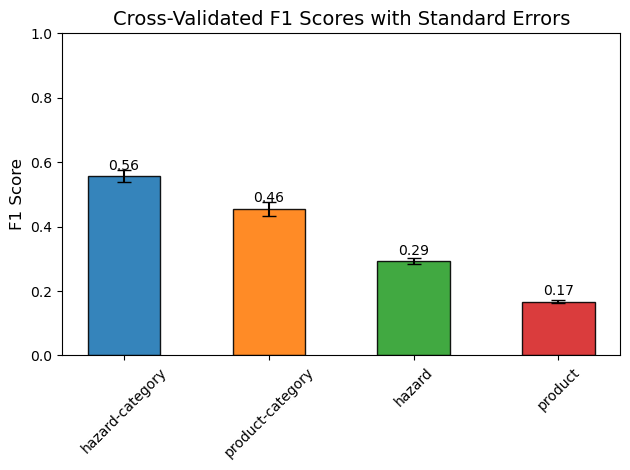

In [ ]:
plot_cv_scores(macro_f1_scores) # plot the cross validated mean macro f1 scores along with standard error

And how it does for the various classes (over cross-validation)

In [ ]:
print_cr(classification_reports, label='hazard-category')

,precision,recall,f1-score,support
allergens,0.78,0.77,0.78,1874
biological,0.79,0.84,0.81,1720
chemical,0.68,0.62,0.65,291
food additives and flavourings,0.35,0.25,0.28,29
foreign bodies,0.59,0.59,0.59,531
fraud,0.61,0.55,0.58,405
organoleptic aspects,0.31,0.27,0.28,58
other hazard,0.58,0.53,0.55,128
packaging defect,0.42,0.43,0.42,48
macro avg,0.58,0.55,0.56,5085


#### 1.2 k=7

--------------------
FOLD 1
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.53 | Micro F1: 0.75
Target: PRODUCT-CATEGORY | Macro F1: 0.44 | Micro F1: 0.62
Target: HAZARD | Macro F1: 0.21 | Micro F1: 0.49
Target: PRODUCT | Macro F1: 0.13 | Micro F1: 0.29
--------------------
FOLD 2
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.48 | Micro F1: 0.77
Target: PRODUCT-CATEGORY | Macro F1: 0.49 | Micro F1: 0.63
Target: HAZARD | Macro F1: 0.22 | Micro F1: 0.50
Target: PRODUCT | Macro F1: 0.15 | Micro F1: 0.30
--------------------
FOLD 3
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.58 | Micro F1: 0.76
Target: PRODUCT-CATEGORY | Macro F1: 0.49 | Micro F1: 0.61
Target: HAZARD | Macro F1: 0.21 | Micro F1: 0.49
Target: PRODUCT | Macro F1: 0.13 | Micro F1: 0.30
--------------------
FOLD 4
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.44 | Micro F1: 0.75
Target: PRODUCT-CATEGORY | Macro F1: 0.41 | Micro F1: 0.63
Target: HAZARD | Macro F1: 0.23 | Micro

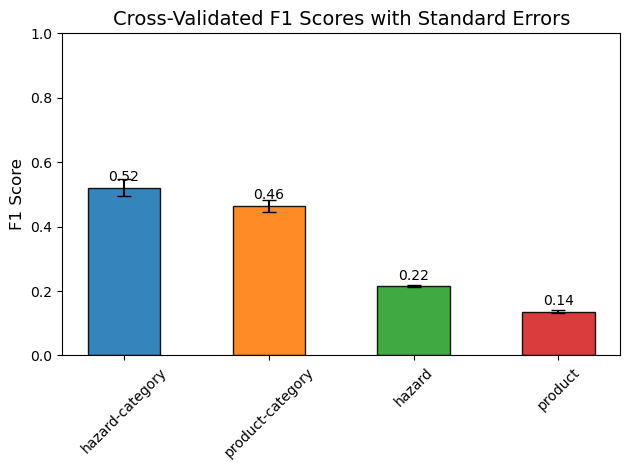

,precision,recall,f1-score,support
allergens,0.74,0.89,0.80,1874
biological,0.77,0.88,0.82,1720
chemical,0.78,0.46,0.58,291
food additives and flavourings,0.67,0.30,0.40,29
foreign bodies,0.80,0.56,0.66,531
fraud,0.85,0.50,0.63,405
organoleptic aspects,0.75,0.21,0.32,58
other hazard,0.64,0.21,0.32,128
packaging defect,0.80,0.15,0.25,48
macro avg,0.74,0.45,0.52,5085


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=7)
results, feature_names = experiment(classifier, feature='title')

# Access F1 scores
macro_f1_scores = results['f1_scores']
classification_reports = results['reports']
confusion_matrices = results['cms']

print_cv_scores(macro_f1_scores)
plot_cv_scores(macro_f1_scores)
print_cr(classification_reports, label='hazard-category')

#### Optimizing over k

Let's search for the best $k\in \{1,...,7 \}$

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

data = {} # Store the scores here
for k in range(1,8):
    # Try kNN for k
    classifier = KNeighborsClassifier(n_neighbors=k)
    results, feature_names = experiment(classifier, feature='title')

    # Access F1 scores
    macro_f1_scores = results['f1_scores']

    # Store f1 scores
    data[k] = macro_f1_scores
data

--------------------
FOLD 1
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.53 | Micro F1: 0.73
Target: PRODUCT-CATEGORY | Macro F1: 0.42 | Micro F1: 0.59
Target: HAZARD | Macro F1: 0.28 | Micro F1: 0.48
Target: PRODUCT | Macro F1: 0.16 | Micro F1: 0.32
--------------------
FOLD 2
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.50 | Micro F1: 0.75
Target: PRODUCT-CATEGORY | Macro F1: 0.54 | Micro F1: 0.60
Target: HAZARD | Macro F1: 0.28 | Micro F1: 0.47
Target: PRODUCT | Macro F1: 0.18 | Micro F1: 0.32
--------------------
FOLD 3
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.59 | Micro F1: 0.73
Target: PRODUCT-CATEGORY | Macro F1: 0.43 | Micro F1: 0.59
Target: HAZARD | Macro F1: 0.33 | Micro F1: 0.47
Target: PRODUCT | Macro F1: 0.17 | Micro F1: 0.31
--------------------
FOLD 4
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.58 | Micro F1: 0.72
Target: PRODUCT-CATEGORY | Macro F1: 0.44 | Micro F1: 0.59
Target: HAZARD | Macro F1: 0.27 | Micro

{1: {'hazard-category': [0.5348037496724529,
   0.49974329824518665,
   0.5917210611965311,
   0.5803210413938739,
   0.5789263868466066],
  'product-category': [0.4174803721455692,
   0.543794149777895,
   0.432508249939232,
   0.44398870597506984,
   0.43830531813708495],
  'hazard': [0.2842318069593751,
   0.2832788841962113,
   0.3256457948102505,
   0.27292000340529277,
   0.2997092852645553],
  'product': [0.15762658749564223,
   0.17830800657604756,
   0.1741491373163999,
   0.167538185858539,
   0.15398605960562006]},
 2: {'hazard-category': [0.52825072186952,
   0.4535929149423787,
   0.5065996278205677,
   0.41309746470440684,
   0.4868383982925492],
  'product-category': [0.37091725996040564,
   0.5000407108547288,
   0.3918987114122693,
   0.36260949034935086,
   0.4205857196228857],
  'hazard': [0.24041159279944951,
   0.25721311863576374,
   0.25953458838159665,
   0.23066836293997703,
   0.25356751096131824],
  'product': [0.11641604640007876,
   0.15892980402102125,
   

Now we can **calculate** the mean macro $F_1$ scores for each model and compare:

In [ ]:
# Turn dictionary into one, malleable dataframe
for k in range(1,8):
    data[k] = pd.DataFrame(data[k])
    data[k]['neighbors'] = k
df = pd.concat(data.values())

# Group by k and aggregate
grouped_df = df.groupby('neighbors').agg(['mean', 'sem']).round(4)
grouped_df

hazard-category         product-category          hazard          \
                     mean     sem             mean     sem    mean     sem   
neighbors                                                                    
1                  0.5571  0.0173           0.4552  0.0226  0.2932  0.0092   
2                  0.4777  0.0203           0.4092  0.0248  0.2483  0.0055   
3                  0.5446  0.0160           0.4220  0.0181  0.2467  0.0094   
4                  0.5264  0.0208           0.4381  0.0190  0.2480  0.0076   
5                  0.5303  0.0180           0.4563  0.0201  0.2365  0.0063   
6                  0.5270  0.0224           0.4586  0.0210  0.2264  0.0069   
7                  0.5210  0.0258           0.4648  0.0184  0.2154  0.0039   

          product          
             mean     sem  
neighbors                  
1          0.1663  0.0047  
2          0.1373  0.0076  
3          0.1316  0.0053  
4          0.1341  0.0050  
5          0.1324  0.0058  
6          0.1349  0.0060  
7          0.1364  0.0051

But as always, it is better to **visualize**.

c:\Users\stefa\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


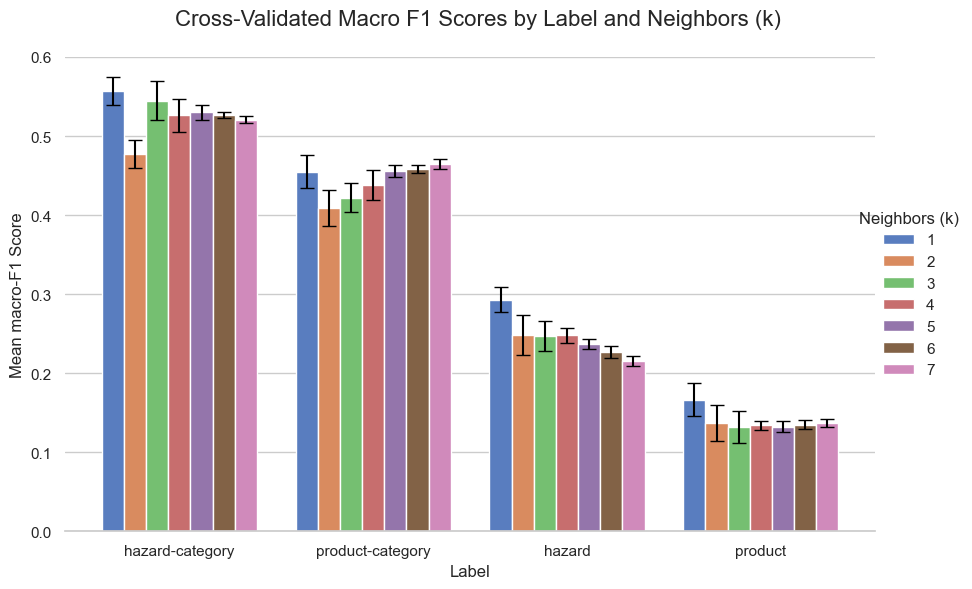

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Reshape the DataFrame
long_df = grouped_df.reset_index()  # Reset index to make 'neighbors' a column
long_df = long_df.melt(id_vars='neighbors', var_name=['category', 'metric'], value_name='value')

# Separate means and standard errors
mean_df = long_df[long_df['metric'] == 'mean']
sem_df = long_df[long_df['metric'] == 'sem']

# Merge the means and standard errors into one DataFrame
mean_df = mean_df.rename(columns={'value': 'mean'})
sem_df = sem_df.rename(columns={'value': 'sem'})
merged_df = pd.merge(mean_df, sem_df, on=['neighbors', 'category'])

# Create the bar plot with error bars
sns.set_style("whitegrid")
g = sns.catplot(
    data=merged_df,
    kind="bar",
    x="category",  # Feature categories
    y="mean",      # Mean F1 scores
    hue="neighbors",  # Different k values
    palette="muted",
    height=6,
    aspect=1.5,
    errorbar=None
)

# Add error bars manually
ax = g.ax  # Access the Axes object from the FacetGrid
for i, patch in enumerate(ax.patches):
    # Determine the category and neighbor corresponding to this bar
    category = merged_df['category'].unique()[i // len(merged_df['neighbors'].unique())]
    neighbors = merged_df['neighbors'].unique()[i % len(merged_df['neighbors'].unique())]

    # Get the corresponding error value
    error = merged_df[(merged_df['category'] == category) & (merged_df['neighbors'] == neighbors)]['sem'].values[0]

    # Add error bar
    bar_center = patch.get_x() + patch.get_width() / 2  # Center of the bar
    ax.errorbar(bar_center, patch.get_height(), yerr=error, fmt='none', capsize=5, color='black')

# Customize plot appearance
g.set_axis_labels("Label", "Mean macro-F1 Score")
g.set_titles("Cross-Validated Macro F1 Scores with Standard Errors")
g.set(ylim=(0, 0.6))  # Set F1 score range
g.despine(left=True)
g._legend.set_title("Neighbors (k)")

# Add title to the figure
g.fig.suptitle("Cross-Validated Macro F1 Scores by Label and Neighbors (k)", fontsize=16)

# Adjust layout to prevent overlap
g.fig.subplots_adjust(top=0.9)

# Show the plot
plt.show()


* First of all, we notice $k=1$ generally does better than the rest.

* Especially in the `hazard` and `product` labels, where the score decreases as $k$ increases. That is normal considering the severe class imbalance. For categories with as little as one example, $k>1$ will result in bias towards majority classes, decreasing the macro-$F_1$ score.

* For `hazard-category` though, $k=3$ might be just as good, as it has about the same mean and standard error.

* For `product-category`, it is surprising that $k=7$ is an exception to the rule: not only does it do better than $k=1$, but also it has less $\operatorname{s.e.}$

* But $k=1$ is an "iffy" choice because it is susceptible to minor changes in the data.

### 2. Support Vector Machines

SVMs, though a basic classifier, have been proven to often outperform far more complicated classifiers, with the right hyperparameter tuning. So they are a justified choice for our second model. From the non-parametric k-NN, we will go to the basic but powerful SVMs and perform some hyperparameter tuning.

SVM classification tries to seperate two classes with a hyperplane in some transformed feature space. It tries to find the hyperplane that leaves maximum margin from both classes, i.e. that leaves the same distance from the nearest points.(support vectors) from each class.




Here I setup a little "playground" to try and "get a feel" for the perfomance of the different combinations of parameters.

[LibSVM]
HAZARD-CATEGORY: macro 0.4466 | micro 0.7217
                                precision    recall  f1-score   support

                     allergens       0.79      0.82      0.81       371
                    biological       0.89      0.74      0.81       348
                      chemical       0.57      0.53      0.55        57
food additives and flavourings       0.25      0.40      0.31         5
                foreign bodies       0.68      0.68      0.68       112
                         fraud       0.70      0.57      0.63        74
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       0.20      0.27      0.23        11
                  other hazard       0.29      0.56      0.38        27
              packaging defect       0.05      0.18      0.08        11

                      accuracy                           0.72      1017
                     macro avg       0.44      0.47      0.45      1017
        

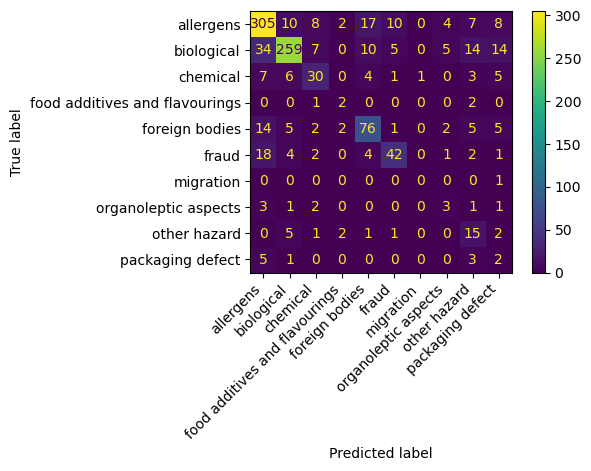

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

target_variable = 'hazard'

def experiment_svm(feature, target_variable, scaler, classifier):
    if scaler is not None:
        text_clf = Pipeline([
                ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1), max_df=0.5, min_df=5)),
                ('scaler', scaler),
                ('clf', classifier)
            ])
    else:
        text_clf = Pipeline([
                ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1), max_df=0.5, min_df=5)),
                ('clf', classifier)
            ])

    train, dev = train_test_split(incidents, test_size=0.2, random_state=2024, stratify=incidents[target_variable])

    text_clf.fit(train[feature], train[target_variable])
    dev['predictions-' + target_variable] = text_clf.predict(dev[feature])

    # Scorings
    macro_f1 = f1_score(dev[target_variable], dev['predictions-' + target_variable], zero_division=0, average="macro")
    micro_f1 = f1_score(dev[target_variable], dev['predictions-' + target_variable], zero_division=0, average="micro")
    report = classification_report(dev[target_variable], dev['predictions-' + target_variable], zero_division=0, output_dict=False)
    cm = confusion_matrix(dev[target_variable], dev['predictions-' + target_variable])

    # Print
    print(f"\n{target_variable.upper()}: macro {macro_f1:.4f} | micro {micro_f1:.4f}")
    # print(report)
    # print(cm)

    return (macro_f1, micro_f1, report, cm)

scaler = MaxAbsScaler()
scaler = StandardScaler(with_mean=False)
scaler = None
clf = SVC(C=1, kernel='linear', class_weight='balanced', verbose=True, max_iter=-1)
feature = 'title'
target_variable = 'hazard-category'

macro_f1, micro_f1, report, cm = experiment_svm(feature, target_variable, scaler, clf)
print(report)

# Confusion matrix display
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### SVM Parameters

1. Scaling

Quoting from sci-kit learn:
> Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. This can be done easily by using a Pipeline

2. Regularization

> Setting C: C is 1 by default and it’s a reasonable default choice. If you have a lot of noisy observations you should decrease it: decreasing C corresponds to more regularization.

3. `class_weight`
In the SVM optimization problem we want to minimize
$$
\operatorname{min} \frac{1}{2}\Vert w \Vert^2 + C \sum_{i=1}^{N}w_{y_i} ξ_i
$$
* The `class_weight` parameter modifies this term to make errors on certain classes (e.g. minority classes) more significant. The weight $w_j$ influences the penalty for misclassifications during optimization.
* With `class_weight = 'balanced'`, errors on minority class samples (which have higher weights) are penalized more heavily. This forces the model to "pay more attention" to correctly classifying minority class samples.
* The decision boundary shifts to account for the increased importance of the minority class:
* It tries harder to correctly classify minority samples
* The boundary may sacrifice some accuracy for the majority class to improve overall balance

#### Hyperparameter tuning.

We will conduct the following experiment to try and find the best parameter combination for the SVM, specifically for `title` and `hazard-category`.

1. Preprocessing
    1. Vectorize text using TF-IDF
    2. **Scale** the TF-IDF matrix to standardize feature values (SVMs are NOT scale invariant).
2. Hyperparameter tuning
    1. Use **cross-validation** to tune:
        * C: regularization strength
        * kernel: (e.g. linear, rbf)
        * gamma: (for non linear kernels)
    2. Test with **class-weight**=balanced and without
    3. Evaluate metrics like precision, recall and F1-score, especially for minority classes.

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import joblib

# Define data
X = incidents['title']
y = incidents['hazard-category']

# Define nested cross-validation settings
outer_cv = KFold(n_splits=3, shuffle=True, random_state=2024)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=2024)

# Define parameter grids for different kernels
param_grid = [
    # Try linear kernel combinations
    {
        'scaler': [None, StandardScaler(with_mean=False), MaxAbsScaler()],
        'svm__kernel': ['linear'],
        'svm__C': [0.1, 1, 10, 100],
        'svm__class_weight': ['balanced', None]
    },
    # Try non linear kernel combinations
    {
        'scaler': [None, StandardScaler(with_mean=False), MaxAbsScaler()],
        'svm__kernel': ['rbf', 'poly'],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'svm__class_weight': ['balanced', None]
    }
]

# Lists to store results
best_models = []
best_params = []
nested_scores = []

# Create a pipeline with placeholder scaler and SVM
pipeline = Pipeline([
    ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1), max_df=0.5, min_df=5)),
    ('scaler', None),
    ('svm', SVC())
])

# Perform nested cross-validation
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    # Split data for outer fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Set up GridSearchCV for the inner loop
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=make_scorer(f1_score, average='macro'),
        cv=inner_cv,
        n_jobs=-1,
        verbose=2
    )

    # Fit GridSearchCV on the training data of the outer fold
    grid_search.fit(X_train, y_train)

    # Save the best model and parameters for this fold
    best_model = grid_search.best_estimator_
    best_models.append(best_model)
    best_params.append(grid_search.best_params_)

    # Evaluate the best model on the test data of the outer fold
    test_predictions = best_model.predict(X_test)
    fold_score = f1_score(y_test, test_predictions, average='macro')
    nested_scores.append(fold_score)

    # Save the best model to disk
    joblib.dump(best_model, f"best_model_fold_{i+1}.joblib")

# Output results
print(f"Nested CV F1 Scores: {nested_scores}")
print(f"Mean Nested CV F1 Score: {np.mean(nested_scores):.4f}")

# Print best parameters for each fold
for i, params in enumerate(best_params):
    print(f"Outer Fold {i+1}: Best Parameters: {params}")


Fitting 3 folds for each of 264 candidates, totalling 792 fits
Fitting 3 folds for each of 264 candidates, totalling 792 fits
Fitting 3 folds for each of 264 candidates, totalling 792 fits
Nested CV F1 Scores: [0.5651030818941731, 0.5804198946263113, 0.5499154337967773]
Mean Nested CV F1 Score: 0.5651
Outer Fold 1: Best Parameters: {'scaler': None, 'svm__C': 10, 'svm__class_weight': None, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Outer Fold 2: Best Parameters: {'scaler': MaxAbsScaler(), 'svm__C': 1, 'svm__class_weight': None, 'svm__kernel': 'linear'}
Outer Fold 3: Best Parameters: {'scaler': MaxAbsScaler(), 'svm__C': 10, 'svm__class_weight': None, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


One thing all folds agree on is `class_weight=None`, which is surprising, since `'balanced'` forces the model to pay attention to minority classes, and *should* lead to an improved macro F1 score.

Another is `gamma=0.1`, for `rbf` kernels.

In two cases out of three:
* the `MaxAbsScaler()` does better, but for different kernels
* C = 10, but with different kernels
* `kernel='rbf'`, but with different scalings.

Conclusion:
* C=10 does well with rbf kernels, while C=1 with linear kernels
* MaxAbsScaler() helps the linear kernel(?), but not necessarily the rbf kernel.
* class_weight should remain None
* gamma is set to 0.1 for rbf kernels

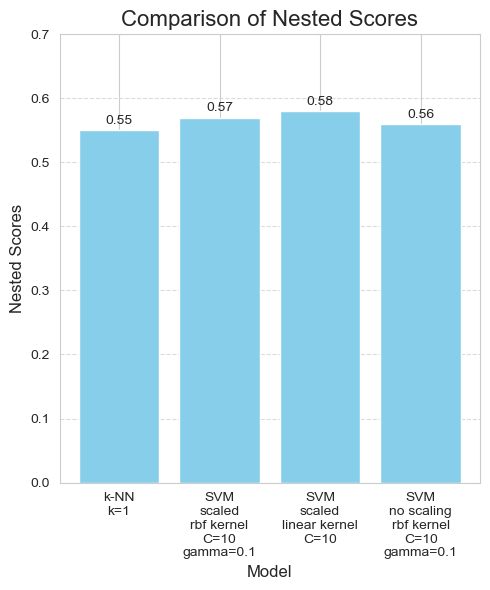

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace these with your actual variables)
best_model_names = ['k-NN\nk=1', 'SVM\nscaled\nrbf kernel\nC=10\ngamma=0.1', 'SVM\nscaled\nlinear kernel\nC=10', 'SVM\nno scaling\nrbf kernel\nC=10\ngamma=0.1']
nested_scores_with_knn = [0.55, 0.57, 0.58, 0.56]

# Plot
plt.figure(figsize=(5, 6))  # Adjust figure size
plt.bar(best_model_names, nested_scores_with_knn, color='skyblue')
plt.title('Comparison of Nested Scores', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Nested Scores', fontsize=12)
#plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.ylim(0, 0.7)  # Set an appropriate limit for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate values
for i, score in enumerate(nested_scores_with_knn):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', fontsize=10)

plt.tight_layout()  # Ensure everything fits well
plt.show()


In the end, for `hazard-category`, the tuned SVMs (best score **0.5804**) are barely better than $k$-NN with $k=1$ (best score **0.5571**). But what about the other labels?

Let's see how the models do for the other labels.

In [ ]:
model_results = {}
for i, model in enumerate(best_models):
    print(f"Evaluating model: {model}")
    results, feature_names = experiment(model, feature='title')

    # Store results
    model_results[i] = results

Evaluating model: Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.5, min_df=5,
                                 strip_accents='unicode')),
                ('scaler', None), ('svm', SVC(C=10, gamma=0.1))])
--------------------
FOLD 1
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.66 | Micro F1: 0.83
Target: PRODUCT-CATEGORY | Macro F1: 0.51 | Micro F1: 0.70
Target: HAZARD | Macro F1: 0.29 | Micro F1: 0.59
Target: PRODUCT | Macro F1: 0.20 | Micro F1: 0.41
--------------------
FOLD 2
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.64 | Micro F1: 0.83
Target: PRODUCT-CATEGORY | Macro F1: 0.59 | Micro F1: 0.70
Target: HAZARD | Macro F1: 0.32 | Micro F1: 0.61
Target: PRODUCT | Macro F1: 0.23 | Micro F1: 0.41
--------------------
FOLD 3
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.64 | Micro F1: 0.82
Target: PRODUCT-CATEGORY | Macro F1: 0.60 | Micro F1: 0.71
Target: HAZARD | Macro F1: 0.36 | Micro F1: 0.62
Target: PRODUCT | Macro F1: 0.2

#### Visualization

We want to compare the performance of our models so far across all labels.

In [ ]:
# Train a knn to compare:
classifier = KNeighborsClassifier(n_neighbors=1)
results, feature_names = experiment(classifier, feature='title')

# Access F1 scores
kNN_macro_f1_scores = results['f1_scores']

--------------------
FOLD 1
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.53 | Micro F1: 0.73
Target: PRODUCT-CATEGORY | Macro F1: 0.42 | Micro F1: 0.59
Target: HAZARD | Macro F1: 0.28 | Micro F1: 0.48
Target: PRODUCT | Macro F1: 0.16 | Micro F1: 0.32
--------------------
FOLD 2
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.50 | Micro F1: 0.75
Target: PRODUCT-CATEGORY | Macro F1: 0.54 | Micro F1: 0.60
Target: HAZARD | Macro F1: 0.28 | Micro F1: 0.47
Target: PRODUCT | Macro F1: 0.18 | Micro F1: 0.32
--------------------
FOLD 3
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.59 | Micro F1: 0.73
Target: PRODUCT-CATEGORY | Macro F1: 0.43 | Micro F1: 0.59
Target: HAZARD | Macro F1: 0.33 | Micro F1: 0.47
Target: PRODUCT | Macro F1: 0.17 | Micro F1: 0.31
--------------------
FOLD 4
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.58 | Micro F1: 0.72
Target: PRODUCT-CATEGORY | Macro F1: 0.44 | Micro F1: 0.59
Target: HAZARD | Macro F1: 0.27 | Micro

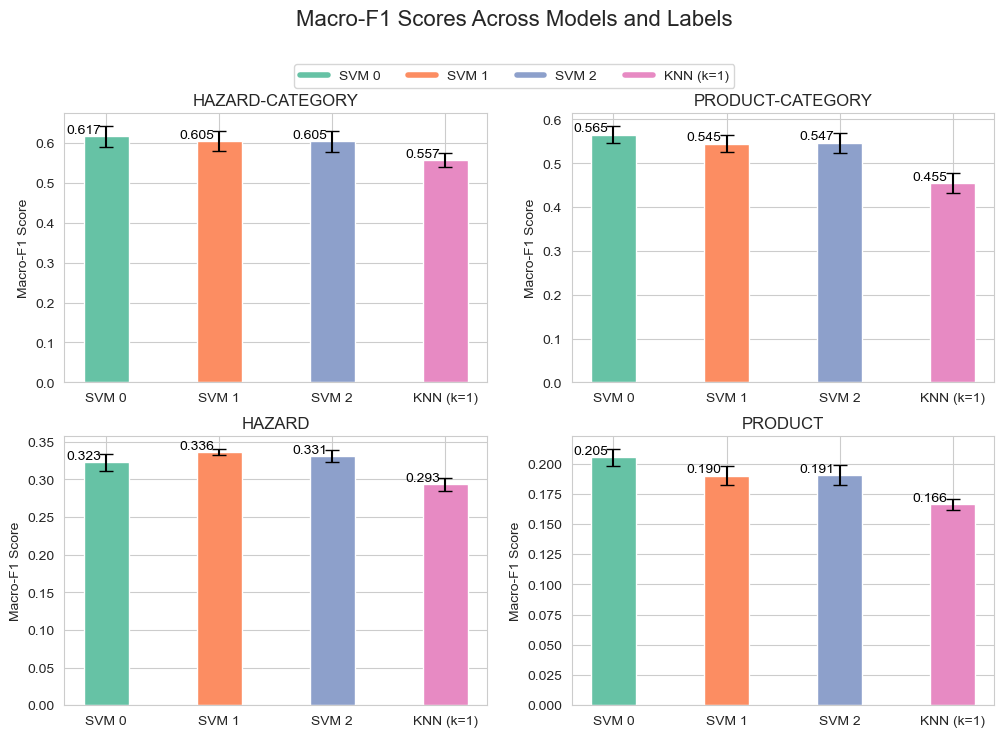

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use a Seaborn color palette and set style
sns.set_style("whitegrid")
palette = sns.color_palette("Set2", n_colors=4)  # Adjust n_colors to match the models, including KNN

# Prepare a DataFrame to store macro-F1 scores for all models and labels
data = []

# Existing model results
for model_id, results in model_results.items():
    for label, scores in results['f1_scores'].items():
        for score in scores:
            data.append({'Model': model_id, 'Label': label, 'F1 Score': score})

# Add KNN results
knn_model_id = max(model_results.keys()) + 1  # Assign KNN a new model ID
for label, scores in kNN_macro_f1_scores.items():
    for score in scores:
        data.append({'Model': knn_model_id, 'Label': label, 'F1 Score': score})

# Convert to DataFrame
df = pd.DataFrame(data)

# Group by Model and Label to compute mean and SEM
summary = df.groupby(['Model', 'Label'])['F1 Score'].agg(['mean', 'sem']).reset_index()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Define label-to-position mapping
labels = {'hazard-category': (0, 0),
          'product-category': (0, 1),
          'hazard': (1, 0),
          'product': (1, 1)}

# Plot each label in its own subplot
for label, pos in labels.items():
    subset = summary[summary['Label'] == label]
    ax = axes[pos]
    # Assign colors dynamically using the Seaborn palette
    bar_colors = [palette[model] for model in subset['Model']]
    bars = ax.bar(subset['Model'], subset['mean'], yerr=subset['sem'], capsize=5, color=bar_colors, width=0.4)
    ax.set_title(f'{label.upper()}')
    #ax.set_xlabel('Model')
    ax.set_ylabel('Macro-F1 Score')
    ax.set_xticks(subset['Model'])
    ax.set_xticklabels([f"SVM {m}" if m < knn_model_id else "KNN (k=1)" for m in subset['Model']])

    # Add annotations for the scores with adjusted x-position
    for bar, mean in zip(bars, subset['mean']):
        ax.text(bar.get_x() + bar.get_width() / 2 - 0.2, bar.get_height(), f"{mean:.3f}",
                ha='center', va='bottom', fontsize=10, color='black')

# Add a main title to the figure
fig.suptitle("Macro-F1 Scores Across Models and Labels", fontsize=16)

# Add a legend with KNN
custom_lines = [plt.Line2D([0], [0], color=palette[i], lw=4) for i in range(len(palette))]
fig.legend(custom_lines, [f"SVM {i}" if i < knn_model_id else "KNN (k=1)" for i in range(len(palette))],
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 0.92))

# Adjust spacing to fit everything nicely
fig.subplots_adjust(top=0.85)

# Show the grid of plots
plt.show()


So SVMs were an improvement.
* For ST1 labels, SVM 0 (unscaled, C=10, gamma=0.1 and rbf kernel) definitely does better, although the difference from the other SVMs is small.
* In `HAZARD`, SVMs do better than the kNN. SVM 1 in particular (linear kernel and C=1 with MaxAbsScaler) has less error and greater mean compared to the other two.
* But it is in `PRODUCT` that our SVMs make us proud! A 20% improvement from the kNN, $k=1$

### 3. XGBoost

[documentation](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

[Multi-class classification with XGBClassifier (objective)](https://stackoverflow.com/questions/57986259/multiclass-classification-with-xgboost-classifier)

[Categorical data](https://xgboost.readthedocs.io/en/latest/tutorials/categorical.html)

In [ ]:
%pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.8/124.9 MB 5.6 MB/s eta 0:00:23
    --------------------------------------- 1.6/124.9 MB 4.2 MB/s eta 0:00:30
    --------------------------------------- 2.9/124.9 MB 4.9 MB/s eta 0:00:25
   - -------------------------------------- 4.2/124.9 MB 5.4 MB/s eta 0:00:23
   - -------------------------------------- 5.5/124.9 MB 5.5 MB/s eta 0:00:22
   -- ------------------------------------- 6.8/124.9 MB 5.7 MB/s eta 0:00:21
   -- ------------------------------------- 8.1/124.9 MB 5.7 MB/s eta 0:00:21
   --- ------------------------------------ 9.4/124.9 MB 5.6 MB/s eta 0:00:21
   --- ------------------------------------ 10.5/124.9 MB 5.6 MB/s eta 0:00:21
   --- ------------------------------------ 11.8/124.9 MB 5.6 MB/s eta 0:00:21
   ---- ----------------------------------- 13.1/124.9 MB 5.7 MB/s eta 0:00:20
   ---- ----------------------------------- 14.4/124.9 MB 5.7 MB/s e


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Prepare data to be passed as categories:

In [ ]:
# Turn all labels into categories
for label in ('hazard-category', 'product-category', 'hazard', 'product'):
    incidents[label] = incidents[label].astype("category")
# Ensure changes are saved
incidents.dtypes

year                   int64
month                  int64
day                    int64
country               object
title                 object
text                  object
hazard-category     category
product-category    category
hazard              category
product             category
dtype: object

Why You Need Label Encoding:

The **target labels** (`hazard-category`) are categorical strings like 'allergens', 'chemical', etc.
These are not features; they are the **labels to predict**, and XGBoost requires these to be integers.

In [16]:
import pandas as pd

incidents = pd.read_csv('https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_train.csv')
incidents.head()

,Unnamed: 0,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


In [24]:
incidents['hazard'].value_counts()

,count
hazard,
listeria monocytogenes,665
salmonella,621
milk and products thereof,588
escherichia coli,237
peanuts and products thereof,211
...,...
dioxins,3
staphylococcal enterotoxin,3
dairy products,3


We start by training our first model with somewhat random parameters, to see how it behaves.

In [30]:
from google.colab import drive
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Mount Google Drive
drive.mount('/content/drive')

# We are using titles to classify
feature = 'title'

# Store scores for each label
macro_f1_xgboost_clf = {label: [] for label in ('hazard-category', 'product-category', 'hazard', 'product')}

# For each label get the score
for label in ('hazard-category', 'product-category', 'hazard', 'product'):
    print(f"{label.upper()}")
    # Initialize encoder and fit to all data
    label_encoder = LabelEncoder()
    label_encoder.fit(incidents[label])

    # Remove classes with less than 2 examples
    class_counts = incidents[label].value_counts()
    classes_to_remove = class_counts[class_counts < 2].index
    data = incidents[~incidents[label].isin(classes_to_remove)]

    # 5-fold Monte Carlo Cross Validation
    for i in range(5):
        # Split data for training and developing using different random seed
        train, dev = train_test_split(data, test_size=0.2, random_state=2024+i, stratify=data[label])
        X_train = train[feature]
        y_train = train[label]
        X_dev = dev[feature]
        y_dev = dev[label]

        # Encode string labels into integers
        y_train_encoded = label_encoder.transform(y_train)
        y_dev_encoded = label_encoder.transform(y_dev)

        # Filter dev set to only include classes seen in training set
        train_classes = set(y_train_encoded)
        valid_indices = [i for i, label in enumerate(y_dev_encoded) if label in train_classes]
        X_dev = X_dev.iloc[valid_indices]
        y_dev_encoded = y_dev_encoded[valid_indices]

        # Create model instance
        clf = XGBClassifier(tree_method='hist',
                            n_estimators=3,
                            max_depth=2,
                            learning_rate=1,
                            objective='multi:softmax')

        # Define a pipeline
        model = Pipeline([
            ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='word', max_df=0.5, min_df=1)),
            ('clf', clf)
        ])

        # fit model
        print(f"Fitting fold {i+1}")
        model.fit(X_train, y_train_encoded)

        # make predictions
        preds = model.predict(X_dev)

        # Make predictions
        preds_encoded = model.predict(X_dev)

        # Decode predictions back to original string labels
        preds = label_encoder.inverse_transform(preds_encoded)

        # Store results
        macro_f1 = f1_score(y_dev, preds, zero_division=0, average="macro")
        print(f"{macro_f1:.3f}")
        macro_f1_xgboost_clf[label].append(macro_f1)

        # Save model to google drive
        model_path = '/content/drive/My Drive/PDS-A2/models/' + f"xgboost_{label}_{i}.pkl"
        with open(model_path, 'wb') as file:
            pickle.dump(model, file)  # Save the entire pipeline


print(pd.DataFrame(macro_f1_xgboost_clf).agg(['mean', 'max']).round(3))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
HAZARD-CATEGORY
Fitting fold 1
0.483
Fitting fold 2
0.473
Fitting fold 3
0.425
Fitting fold 4
0.520
Fitting fold 5
0.441
PRODUCT-CATEGORY
Fitting fold 1
0.394
Fitting fold 2
0.376
Fitting fold 3
0.377
Fitting fold 4
0.375
Fitting fold 5
0.360
HAZARD
Fitting fold 1
0.123
Fitting fold 2
0.085
Fitting fold 3
0.119
Fitting fold 4
0.109
Fitting fold 5
0.085
PRODUCT
Fitting fold 1


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561 562 563], got [   0    2    4    5    6    8   11   12   13   14   17   18   19   20
   22   24   28   29   30   33   35   38   39   40   41   42   43   48
   49   50   51   53   54   55   56   57   58   60   61   66   67   69
   73   74   76   77   79   80   82   83   86   87   88   91   92   93
   94   95   96   99  100  102  107  108  111  112  113  114  115  116
  117  118  119  122  123  130  132  138  140  141  142  143  144  146
  147  149  150  155  157  159  164  165  166  167  168  169  170  173
  174  175  176  177  178  186  187  194  196  201  204  205  207  208
  209  210  212  213  214  216  219  224  226  228  229  230  231  232
  233  234  235  236  237  239  240  241  242  243  245  246  248  249
  252  253  254  255  257  259  260  261  262  263  264  266  267  268
  269  270  273  274  276  277  278  279  281  282  283  284  287  289
  290  291  292  294  295  296  298  299  300  301  302  303  305  306
  307  309  310  311  313  315  316  317  319  321  322  323  327  329
  333  336  338  339  340  343  346  348  349  350  351  353  354  355
  357  359  360  361  366  368  369  370  372  373  374  376  377  381
  382  386  387  388  392  393  394  396  397  398  399  401  404  406
  407  409  413  415  420  421  423  424  426  427  429  430  432  439
  441  442  443  446  453  454  456  457  458  460  461  462  463  465
  466  468  470  474  476  480  482  483  486  490  491  492  494  495
  500  502  503  506  507  508  509  510  512  513  515  516  520  522
  524  528  529  530  532  533  535  537  539  540  541  543  544  545
  547  548  550  552  554  557  559  561  562  567  568  569  570  572
  573  574  575  576  578  580  581  585  586  587  589  591  592  593
  594  595  596  597  598  599  601  603  604  605  608  613  615  616
  617  618  621  622  623  624  628  629  630  631  633  641  642  643
  645  647  648  649  650  659  662  665  666  667  669  670  671  672
  673  677  679  680  681  682  684  685  686  687  688  689  690  693
  694  698  700  705  706  707  709  711  712  713  717  718  720  721
  725  726  727  728  731  732  733  734  735  737  740  742  743  744
  747  748  749  751  752  753  754  755  756  757  758  759  761  763
  764  765  768  770  771  772  775  776  782  789  791  793  794  796
  797  798  802  806  809  810  811  813  814  815  819  820  821  822
  823  825  826  827  829  831  833  834  837  842  844  847  849  854
  856  857  858  860  861  863  865  867  869  870  871  874  875  876
  879  881  885  886  887  894  895  896  897  898  899  901  902  903
  907  908  909  912  913  915  916  917  922  923  928  930  932  933
  935  936  937  938  939  940  941  942  945  946  949  950  951  952
  955  964  965  966  970  971  973  978  979  981  982  987  988  989
  990  992  995  996  997  998  999 1000 1005 1007 1011 1012 1013 1014
 1017 1018 1020 1021]

Confusion matrix

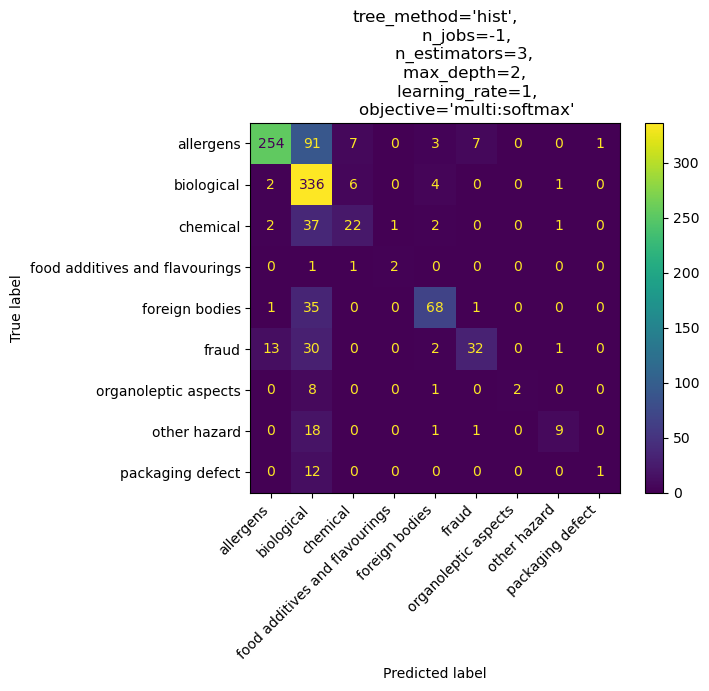

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ax = ConfusionMatrixDisplay.from_predictions(y_dev, preds)
plt.xticks(rotation=45, ha='right')
plt.title("""tree_method='hist',
            n_jobs=-1,
            n_estimators=3,
            max_depth=2,
            learning_rate=1,
            objective='multi:softmax'""")
plt.show()


Change some parameters and try again:

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Load your data
texts = incidents['title'].values
labels = incidents['hazard-category'].values

# Step 1: Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(texts).toarray()

# Step 2: Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train an XGBoost model
model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    njobs=-1
)

model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))


Accuracy: 0.8112094395280236

Classification Report:
                                 precision    recall  f1-score   support

                     allergens       0.81      0.91      0.85       377
                    biological       0.81      0.93      0.86       339
                      chemical       0.83      0.57      0.68        68
food additives and flavourings       1.00      0.20      0.33         5
                foreign bodies       0.87      0.69      0.77       111
                         fraud       0.80      0.54      0.65        68
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       0.50      0.20      0.29        10
                  other hazard       0.86      0.44      0.59        27
              packaging defect       0.00      0.00      0.00        11

                      accuracy                           0.81      1017
                     macro avg       0.65      0.45      0.50      1017
        

Confusion Matrix

Text(0.5, 1.0, "objective='multi:softmax',\n    num_class=len(label_encoder.classes_),\n    eval_metric='mlogloss',\n    use_label_encoder=False,\n    njobs=-1")

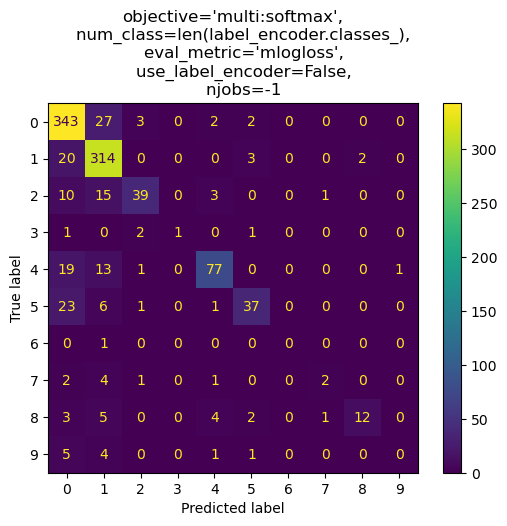

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ax = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("""objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    njobs=-1""")

The second model achieved higher accuracy (0.81 vs 0.71) but lower macro F1 score: 0.50 vs 0.52.

But this is just an observation, as infering which model does better we would need to measure the performance of both using cross validation over multiple folds.

#### Using SMOTE to handle class imbalance (oversamlping)

**SMOTE** (Synthetic Minority Oversampling Technique) is a method used to address class imbalance by **generating synthetic examples for the minority class**. The motivation for using SMOTE is to improve model performance on imbalanced datasets by providing the model with more balanced training data, which helps it learn the characteristics of underrepresented classes effectively.

In [ ]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

# Step 1: Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(incidents['title'].values).toarray()

# Step 2: Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(incidents['hazard-category'].values)

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Train an XGBoost model
model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    njobs=-1
)

model.fit(X_train_resampled, y_train_resampled)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)

# Decode predictions
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_, zero_division=0))


Accuracy: 0.816125860373648

Classification Report:
                                 precision    recall  f1-score   support

                     allergens       0.83      0.89      0.86       377
                    biological       0.83      0.92      0.87       339
                      chemical       0.80      0.66      0.73        68
food additives and flavourings       1.00      0.20      0.33         5
                foreign bodies       0.82      0.72      0.77       111
                         fraud       0.73      0.60      0.66        68
                     migration       1.00      1.00      1.00         1
          organoleptic aspects       0.50      0.20      0.29        10
                  other hazard       0.67      0.44      0.53        27
              packaging defect       0.00      0.00      0.00        11

                      accuracy                           0.82      1017
                     macro avg       0.72      0.56      0.60      1017
         

#### Class Distribution with SMOTE (training set)

We can see how SMOTE made the training set balanced, even for classes with one example.

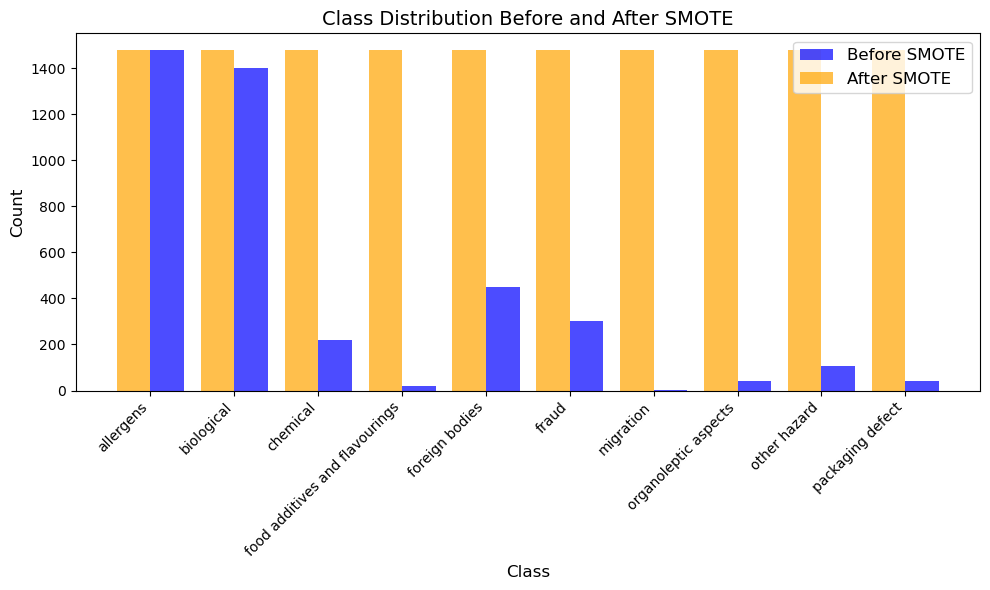

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Before SMOTE
original_counts = Counter(y_train)
after_smote_counts = Counter(y_train_resampled)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    original_counts.keys(),
    original_counts.values(),
    alpha=0.7,
    label="Before SMOTE",
    color="blue",
    width=0.4,
    align="edge",
)
ax.bar(
    after_smote_counts.keys(),
    after_smote_counts.values(),
    alpha=0.7,
    label="After SMOTE",
    color="orange",
    width=-0.4,
    align="edge",
)

# Labeling
ax.set_xlabel("Class", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Class Distribution Before and After SMOTE", fontsize=14)
ax.legend(fontsize=12)
ax.set_xticks(list(original_counts.keys()))
ax.set_xticklabels([label_encoder.inverse_transform([key])[0] for key in original_counts.keys()], rotation=45, ha="right")

# Show plot
plt.tight_layout()
plt.show()


But did it improve performance? Yes! The macro average jumped to 0.60!

#### XGB Setup

We would like to perform some Monte Carlo Cross Validation to gain some statistical knowledge about the performance of this model, but our `experiment` routine from earlier is not complicated enough to account for `SMOTE` and label encoding. We will define a new function, called `xgb_experiment`.

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

def xgb_experiment():
    """5-fold Monte Carlo Cross Validation"""
    # Metrics storage
    results = {
        'f1_scores': {label: [] for label in ('hazard-category', 'product-category', 'hazard', 'product')},
        'reports': {label: [] for label in ('hazard-category', 'product-category', 'hazard', 'product')},
        'cms': {label: [] for label in ('hazard-category', 'product-category', 'hazard', 'product')}
    }

    # 5-fold Monte Carlo Cross Validation
    for i in range(5):
        print("-" * 20)
        print(f"FOLD {i+1}\n" + "-" * 20)
        train, dev = train_test_split(incidents, test_size=0.2, random_state=2024 + i)

        for label in ('hazard-category', 'product-category', 'hazard', 'product'):
            # Classify and collect metrics
            macro_f1, micro_f1, report, cm = classify_target(
                target_variable=label,
                feature=feature,
                text_clf=text_clf,
                train=train,
                dev=dev
            )
            # Store metrics
            results['f1_scores'][label].append(macro_f1)
            results['reports'][label].append(report)
            results['cms'][label].append(cm)

    return results, text_clf.named_steps['vect'].get_feature_names_out()


def inner_xgb_experiment(feature, label, seed):
    # Step 1: Vectorize the text using TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
    X = vectorizer.fit_transform(incidents[feature].values).toarray()

    # Step 2: Encode the labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(incidents[label].values)

    # Step 3: Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024+seed)

    # Step 4: Apply SMOTE
    smote = SMOTE(random_state=42, k_neighbors=1)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Step 5: Train an XGBoost model
    model = xgb.XGBClassifier(
        objective='multi:softmax',  # For multi-class classification
        num_class=len(label_encoder.classes_),
        eval_metric='mlogloss',
        use_label_encoder=False,
        njobs=-1
    )

    model.fit(X_train_resampled, y_train_resampled)

    # Step 6: Evaluate the model
    y_pred = model.predict(X_test)

    # Decode predictions
    y_test_labels = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
    print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_, zero_division=0))


## Classification using text

### k-NN

#### k=1

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=1)
results, feature_names = experiment(classifier, feature='text')

# Access F1 scores
macro_f1_scores = results['f1_scores']
classification_reports = results['reports']
confusion_matrices = results['cms']

--------------------
FOLD 1
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.51 | Micro F1: 0.73
Target: PRODUCT-CATEGORY | Macro F1: 0.44 | Micro F1: 0.54
Target: HAZARD | Macro F1: 0.27 | Micro F1: 0.52
Target: PRODUCT | Macro F1: 0.14 | Micro F1: 0.29
--------------------
FOLD 2
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.48 | Micro F1: 0.74
Target: PRODUCT-CATEGORY | Macro F1: 0.48 | Micro F1: 0.56
Target: HAZARD | Macro F1: 0.32 | Micro F1: 0.55
Target: PRODUCT | Macro F1: 0.16 | Micro F1: 0.29
--------------------
FOLD 3
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.52 | Micro F1: 0.72
Target: PRODUCT-CATEGORY | Macro F1: 0.42 | Micro F1: 0.55
Target: HAZARD | Macro F1: 0.30 | Micro F1: 0.50
Target: PRODUCT | Macro F1: 0.14 | Micro F1: 0.27
--------------------
FOLD 4
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.50 | Micro F1: 0.70
Target: PRODUCT-CATEGORY | Macro F1: 0.40 | Micro F1: 0.55
Target: HAZARD | Macro F1: 0.29 | Micro

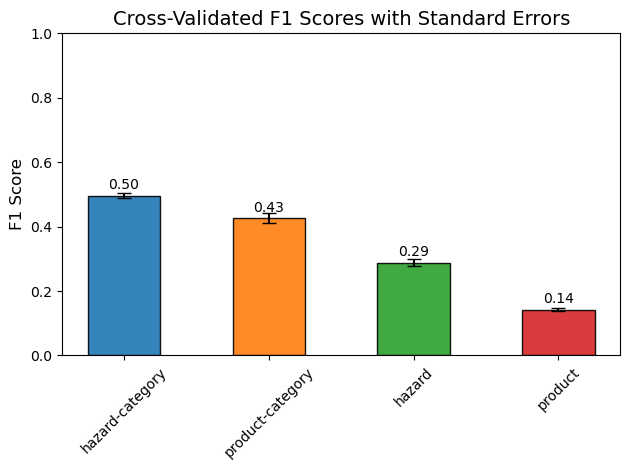

In [ ]:
print_cv_scores(macro_f1_scores)
plot_cv_scores(macro_f1_scores)

#### k=3

--------------------
FOLD 1
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.53 | Micro F1: 0.75
Target: PRODUCT-CATEGORY | Macro F1: 0.37 | Micro F1: 0.52
Target: HAZARD | Macro F1: 0.23 | Micro F1: 0.51
Target: PRODUCT | Macro F1: 0.09 | Micro F1: 0.22
--------------------
FOLD 2
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.50 | Micro F1: 0.76
Target: PRODUCT-CATEGORY | Macro F1: 0.44 | Micro F1: 0.56
Target: HAZARD | Macro F1: 0.29 | Micro F1: 0.54
Target: PRODUCT | Macro F1: 0.11 | Micro F1: 0.24
--------------------
FOLD 3
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.44 | Micro F1: 0.73
Target: PRODUCT-CATEGORY | Macro F1: 0.44 | Micro F1: 0.55
Target: HAZARD | Macro F1: 0.24 | Micro F1: 0.50
Target: PRODUCT | Macro F1: 0.11 | Micro F1: 0.23
--------------------
FOLD 4
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.37 | Micro F1: 0.71
Target: PRODUCT-CATEGORY | Macro F1: 0.33 | Micro F1: 0.51
Target: HAZARD | Macro F1: 0.28 | Micro

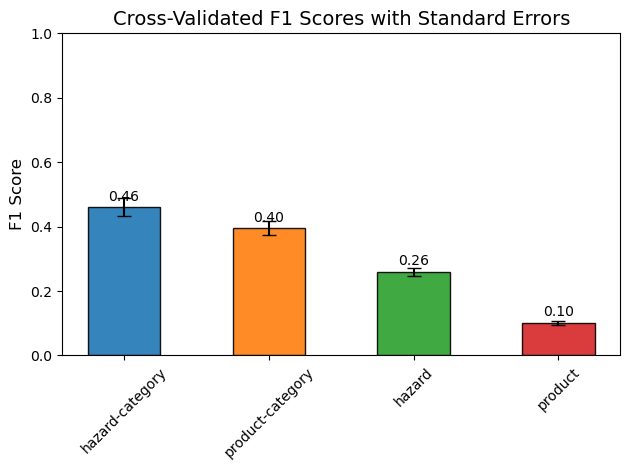

,precision,recall,f1-score,support
allergens,0.72,0.89,0.79,1874
biological,0.77,0.87,0.82,1720
chemical,0.83,0.51,0.63,291
food additives and flavourings,0.82,0.34,0.44,29
foreign bodies,0.70,0.43,0.53,531
fraud,0.64,0.38,0.48,405
organoleptic aspects,0.50,0.06,0.10,58
other hazard,0.55,0.21,0.30,128
packaging defect,0.35,0.08,0.13,48
macro avg,0.64,0.41,0.46,5085


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=3)
results, feature_names = experiment(classifier, feature='text')

# Access F1 scores
macro_f1_scores = results['f1_scores']
classification_reports = results['reports']
confusion_matrices = results['cms']

print_cv_scores(macro_f1_scores)
plot_cv_scores(macro_f1_scores)
print_cr(classification_reports, label='hazard-category')

#### Optimizing over k

Let's search for the best $k\in \{1,...,7 \}$

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

data = {} # Store the scores here
for k in range(1,8):
    # Try kNN for k
    classifier = KNeighborsClassifier(n_neighbors=k)
    results, feature_names = experiment(classifier, feature='text')

    # Access F1 scores
    macro_f1_scores = results['f1_scores']

    # Store f1 scores
    data[k] = macro_f1_scores
data

--------------------
FOLD 1
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.57 | Micro F1: 0.75
Target: PRODUCT-CATEGORY | Macro F1: 0.42 | Micro F1: 0.54
Target: HAZARD | Macro F1: 0.28 | Micro F1: 0.54
Target: PRODUCT | Macro F1: 0.13 | Micro F1: 0.28
--------------------
FOLD 2
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.48 | Micro F1: 0.76
Target: PRODUCT-CATEGORY | Macro F1: 0.46 | Micro F1: 0.56
Target: HAZARD | Macro F1: 0.33 | Micro F1: 0.56
Target: PRODUCT | Macro F1: 0.15 | Micro F1: 0.28
--------------------
FOLD 3
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.50 | Micro F1: 0.71
Target: PRODUCT-CATEGORY | Macro F1: 0.42 | Micro F1: 0.53
Target: HAZARD | Macro F1: 0.30 | Micro F1: 0.51
Target: PRODUCT | Macro F1: 0.14 | Micro F1: 0.26
--------------------
FOLD 4
--------------------
Target: HAZARD-CATEGORY | Macro F1: 0.51 | Micro F1: 0.72
Target: PRODUCT-CATEGORY | Macro F1: 0.39 | Micro F1: 0.55
Target: HAZARD | Macro F1: 0.29 | Micro

{1: {'hazard-category': [0.5740382644626931,
   0.47560626163140973,
   0.4954017287363331,
   0.5050663982961539,
   0.4796309235719744],
  'product-category': [0.421981370653128,
   0.45767233368792193,
   0.4196126157464684,
   0.38928868760984264,
   0.42426982155354565],
  'hazard': [0.28375477588754144,
   0.3323031450222805,
   0.29673860416058473,
   0.2936915209465624,
   0.26649015476908655],
  'product': [0.13242441244350245,
   0.14837757441266639,
   0.1404942134253071,
   0.12955427540641887,
   0.13320728539927634]},
 2: {'hazard-category': [0.47886199017950504,
   0.441636973106742,
   0.4292073522137588,
   0.4021184243451802,
   0.4144329541484174],
  'product-category': [0.34595926182667397,
   0.3968922323390009,
   0.3960660068856081,
   0.34875598328773844,
   0.3625944761642727],
  'hazard': [0.2657144736973775,
   0.27918985714592504,
   0.24482398341033007,
   0.26406229287793,
   0.24043855740162728],
  'product': [0.08539415505406772,
   0.1201544019202192,
 

Now we can **calculate** the mean macro $F_1$ scores for each model and compare:

In [ ]:
# Turn dictionary into one, malleable dataframe
for k in range(1,8):
    data[k] = pd.DataFrame(data[k])
    data[k]['neighbors'] = k
df = pd.concat(data.values())

# Group by k and aggregate
grouped_df = df.groupby('neighbors').agg(['mean', 'sem']).round(4)
grouped_df

hazard-category         product-category  ...  hazard product        
                     mean     sem             mean  ...     sem    mean     sem
neighbors                                           ...                        
1                  0.5059  0.0178           0.4226  ...  0.0108  0.1368  0.0034
2                  0.4333  0.0132           0.3701  ...  0.0072  0.1017  0.0058
3                  0.4729  0.0196           0.3877  ...  0.0104  0.0962  0.0025
4                  0.4623  0.0152           0.3799  ...  0.0077  0.0922  0.0025
5                  0.4734  0.0131           0.3740  ...  0.0060  0.0905  0.0041
6                  0.4729  0.0193           0.3658  ...  0.0100  0.0869  0.0027
7                  0.4668  0.0210           0.3818  ...  0.0125  0.0899  0.0038

[7 rows x 8 columns]

c:\Users\stefa\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


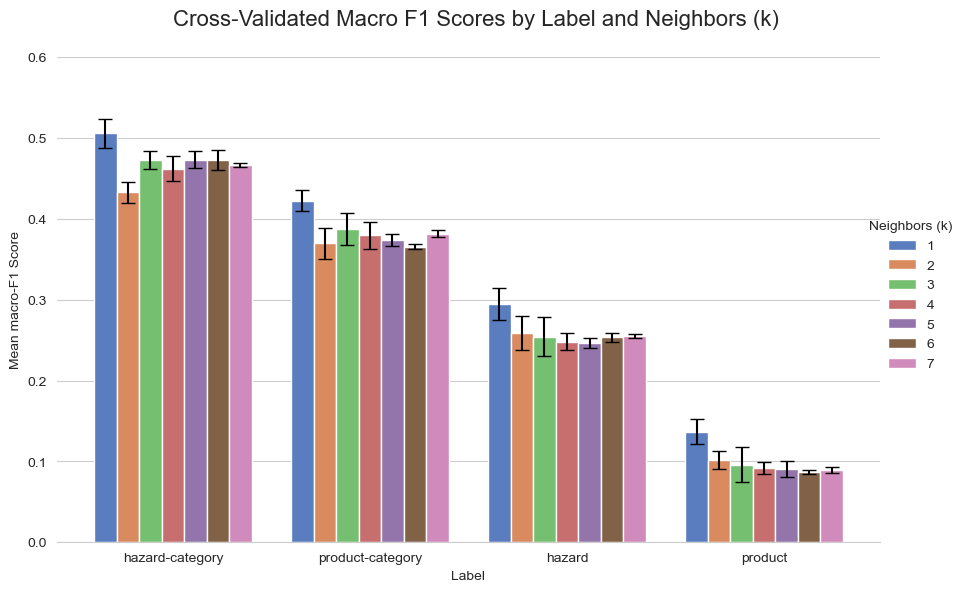

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Reshape the DataFrame
long_df = grouped_df.reset_index()  # Reset index to make 'neighbors' a column
long_df = long_df.melt(id_vars='neighbors', var_name=['category', 'metric'], value_name='value')

# Separate means and standard errors
mean_df = long_df[long_df['metric'] == 'mean']
sem_df = long_df[long_df['metric'] == 'sem']

# Merge the means and standard errors into one DataFrame
mean_df = mean_df.rename(columns={'value': 'mean'})
sem_df = sem_df.rename(columns={'value': 'sem'})
merged_df = pd.merge(mean_df, sem_df, on=['neighbors', 'category'])

# Create the bar plot with error bars
sns.set_style("whitegrid")
g = sns.catplot(
    data=merged_df,
    kind="bar",
    x="category",  # Feature categories
    y="mean",      # Mean F1 scores
    hue="neighbors",  # Different k values
    palette="muted",
    height=6,
    aspect=1.5,
    errorbar=None
)

# Add error bars manually
ax = g.ax  # Access the Axes object from the FacetGrid
for i, patch in enumerate(ax.patches):
    # Determine the category and neighbor corresponding to this bar
    category = merged_df['category'].unique()[i // len(merged_df['neighbors'].unique())]
    neighbors = merged_df['neighbors'].unique()[i % len(merged_df['neighbors'].unique())]

    # Get the corresponding error value
    error = merged_df[(merged_df['category'] == category) & (merged_df['neighbors'] == neighbors)]['sem'].values[0]

    # Add error bar
    bar_center = patch.get_x() + patch.get_width() / 2  # Center of the bar
    ax.errorbar(bar_center, patch.get_height(), yerr=error, fmt='none', capsize=5, color='black')

# Customize plot appearance
g.set_axis_labels("Label", "Mean macro-F1 Score")
g.set_titles("Cross-Validated Macro F1 Scores with Standard Errors")
g.set(ylim=(0, 0.6))  # Set F1 score range
g.despine(left=True)
g._legend.set_title("Neighbors (k)")

# Add title to the figure
g.fig.suptitle("Cross-Validated Macro F1 Scores by Label and Neighbors (k)", fontsize=16)

# Adjust layout to prevent overlap
g.fig.subplots_adjust(top=0.9)

# Show the plot
plt.show()


* For hazard-category and product-category, the performance peaks when $k=1$ (blue bar), then gradually stabilizes or declines slightly with increasing k.
* For hazard and product, a similar trend is observed; $k=1$ generally yields the best scores. As k increases, performance declines, which may indicate that larger k-values introduce noise or reduce the discriminative ability of the classifier for these labels.

### 2. Support Vector Machines

We tried SVMs for `title` classification, it seems reasonable then to continue our analysis for `text` by trying to optimize an SVM for that classifier.

But first, we should get a *feel* for the performance and speed of SVMs with `text` as a starting feature. For the moment we will only try for "**hazard-category**".




#### SVM with linear kernel

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Define our little function
def run_svm_classification(feature, target_variable, scaler, classifier):
    # Initialize pipeline
    text_clf = Pipeline([
            ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1), max_df=0.5, min_df=5)),
            ('scaler', scaler),
            ('clf', classifier)
        ])

    # Stratified train-development split
    train, dev = train_test_split(incidents, test_size=0.2, random_state=2024, stratify=incidents[target_variable])

    # Fit and predict
    text_clf.fit(train[feature], train[target_variable])
    dev['predictions-' + target_variable] = text_clf.predict(dev[feature])
    y_pred = dev['predictions-' + target_variable]
    y_true = dev[target_variable]

    # Scorings
    macro_f1 = f1_score(dev[target_variable], dev['predictions-' + target_variable], zero_division=0, average="macro")
    micro_f1 = f1_score(dev[target_variable], dev['predictions-' + target_variable], zero_division=0, average="micro")
    report = classification_report(dev[target_variable], dev['predictions-' + target_variable], zero_division=0, output_dict=False)
    cm = confusion_matrix(dev[target_variable], dev['predictions-' + target_variable])

    # Print
    print(f"\n{target_variable.upper()}: macro {macro_f1:.4f} | micro {micro_f1:.4f}")
    # print(report)
    # print(cm)

    return (macro_f1, micro_f1, report, cm, y_true, y_pred)

# Various scalers to try
scaler = MaxAbsScaler()
scaler = StandardScaler(with_mean=False)
scaler = None
# Initialize SVM
clf = SVC(C=1, kernel='linear', class_weight='balanced', verbose=3, max_iter=-1)
# Feature->Target definition
feature = 'text'
target_variable = 'hazard-category'

# Run the classification experiment
macro_f1, micro_f1, report, cm, y_true_linear, y_pred_linear = run_svm_classification(feature, target_variable, scaler, clf)
# Classification report
print(report)



[LibSVM]
HAZARD-CATEGORY: macro 0.6228 | micro 0.8663
                                precision    recall  f1-score   support

                     allergens       0.95      0.86      0.91       371
                    biological       0.94      0.93      0.94       348
                      chemical       0.70      0.82      0.76        57
food additives and flavourings       0.67      0.40      0.50         5
                foreign bodies       0.85      0.93      0.89       112
                         fraud       0.57      0.78      0.66        74
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       0.50      0.36      0.42        11
                  other hazard       0.62      0.59      0.60        27
              packaging defect       0.71      0.45      0.56        11

                      accuracy                           0.87      1017
                     macro avg       0.65      0.61      0.62      1017
        

*Right off the bat*, we get a whooping micro F1 (accuracy) of 87%, which means the SVM is overall doing great. But we are interested in **macro F1 score**, which is **0.62**, which is an improvement from the **0.50** of $k$-NNs, which came from $k=1$, which has low bias but high variance, hence poor generalization.

Let's look at the **Confusion Matrix**

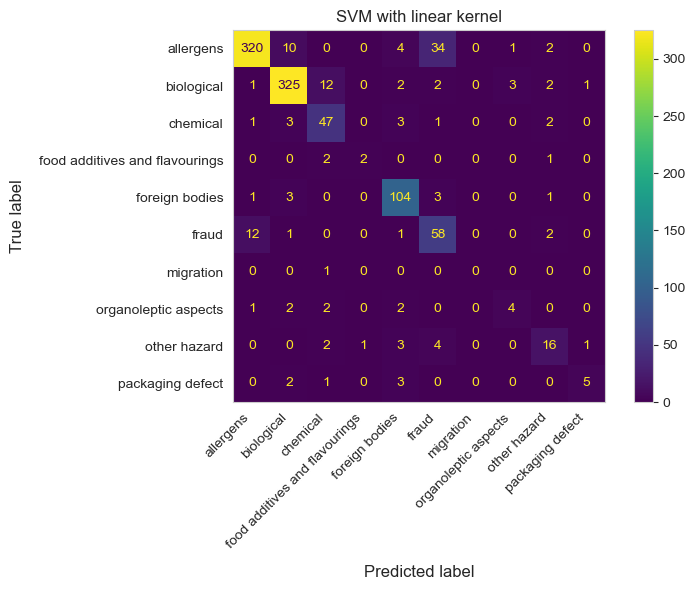

In [ ]:
####################### Confusion matrix display ##########################
# Adjust figure size and layout
fig, ax = plt.subplots(figsize=(8, 6))  # Larger figure size for readability

# Display the confusion matrix with cleaner formatting
disp = ConfusionMatrixDisplay.from_predictions(
    y_true_linear,
    y_pred_linear,
    cmap="viridis",  # Change to a visually appealing color map
    colorbar=True,  # Keep the color bar for context
    ax=ax  # Use our figure's axis
)

# Title
plt.title("SVM with linear kernel")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust rotation and font size
plt.yticks(fontsize=10)  # Adjust y-axis font size

# Remove grid lines explicitly
ax.grid(False)  # Disables gridlines entirely

# Add padding between labels and matrix
plt.xlabel('Predicted label', fontsize=12, labelpad=10)  # Add padding to the x-axis label
plt.ylabel('True label', fontsize=12, labelpad=10)  # Add padding to the y-axis label

# Adjust layout for better fit
plt.tight_layout()

# Show the cleaned-up plot
plt.show()


Confusion Matrix Analysis

Key Observations
1. **Strong Performance**:
   - "Allergens" ($TP = 320$), "Biological" ($TP = 325$), and "Foreign Bodies" ($TP = 104$) show high accuracy with minimal misclassifications.

2. **Weak Classes**:
   - "Migration" ($TP = 0$), "Organoleptic Aspects" ($TP = 4$), and "Packaging Defect" ($TP = 5$) perform poorly, likely due to class imbalance or overlapping features.

3. **Class Confusions**:
   - Significant confusion between "Allergens" and "Biological" (e.g., $FP = 10$).
   - Overlap observed for smaller classes like "Chemical" ($TP = 47$, with $FP = 9$).

4. **Next Steps**:
   - Address imbalanced data for weak classes via oversampling or weighting.
   - Improve feature separation for overlapping classes through feature engineering or non-linear models.


We just used an SVM with no scaling, a linear kernel, balanced class weight, and default regularization parameter $C=1$.

#### SVM with rbf kernel

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Define our little function
def run_svm_classification(feature, target_variable, scaler, classifier):
    # Initialize pipeline
    text_clf = Pipeline([
            ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1), max_df=0.5, min_df=5)),
            ('scaler', scaler),
            ('clf', classifier)
        ])

    # Stratified train-development split
    train, dev = train_test_split(incidents, test_size=0.2, random_state=2024, stratify=incidents[target_variable])

    # Fit and predict
    text_clf.fit(train[feature], train[target_variable])
    dev['predictions-' + target_variable] = text_clf.predict(dev[feature])
    y_pred = dev['predictions-' + target_variable]
    y_true = dev[target_variable]

    # Scorings
    macro_f1 = f1_score(dev[target_variable], dev['predictions-' + target_variable], zero_division=0, average="macro")
    micro_f1 = f1_score(dev[target_variable], dev['predictions-' + target_variable], zero_division=0, average="micro")
    report = classification_report(dev[target_variable], dev['predictions-' + target_variable], zero_division=0, output_dict=False)
    cm = confusion_matrix(dev[target_variable], dev['predictions-' + target_variable])

    # Print
    print(f"\n{target_variable.upper()}: macro {macro_f1:.4f} | micro {micro_f1:.4f}")
    # print(report)
    # print(cm)

    return (macro_f1, micro_f1, report, cm, y_true, y_pred)

# Various scalers to try
scaler = MaxAbsScaler()
scaler = StandardScaler(with_mean=False)
scaler = None
# Initialize SVM
clf = SVC(C=1, kernel='rbf', class_weight='balanced', verbose=3, max_iter=-1)
# Feature->Target definition
feature = 'text'
target_variable = 'hazard-category'

# Run the classification experiment
macro_f1, micro_f1, report, cm, y_true_rbf, y_pred_rbf = run_svm_classification(feature, target_variable, scaler, clf)
# Classification report
print(report)



[LibSVM]
HAZARD-CATEGORY: macro 0.5704 | micro 0.8535
                                precision    recall  f1-score   support

                     allergens       0.95      0.85      0.89       371
                    biological       0.92      0.94      0.93       348
                      chemical       0.72      0.81      0.76        57
food additives and flavourings       0.67      0.40      0.50         5
                foreign bodies       0.75      0.95      0.84       112
                         fraud       0.58      0.78      0.67        74
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       1.00      0.09      0.17        11
                  other hazard       0.63      0.44      0.52        27
              packaging defect       1.00      0.27      0.43        11

                      accuracy                           0.85      1017
                     macro avg       0.72      0.55      0.57      1017
        

Turns out we did slighlty worse with only a change of kernel.

Confusion Matrix

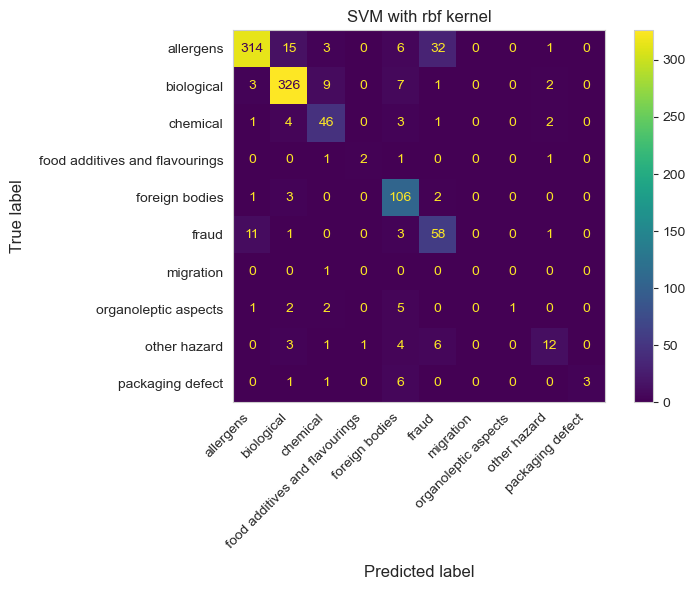

In [ ]:
####################### Confusion matrix display ##########################
# Adjust figure size and layout
fig, ax = plt.subplots(figsize=(8, 6))  # Larger figure size for readability

# Display the confusion matrix with cleaner formatting
disp = ConfusionMatrixDisplay.from_predictions(
    y_true_rbf,
    y_pred_rbf,
    cmap="viridis",  # Change to a visually appealing color map
    colorbar=True,  # Keep the color bar for context
    ax=ax  # Use our figure's axis
)

# Title
plt.title("SVM with rbf kernel")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust rotation and font size
plt.yticks(fontsize=10)  # Adjust y-axis font size

# Remove grid lines explicitly
ax.grid(False)  # Disables gridlines entirely

# Add padding between labels and matrix
plt.xlabel('Predicted label', fontsize=12, labelpad=10)  # Add padding to the x-axis label
plt.ylabel('True label', fontsize=12, labelpad=10)  # Add padding to the y-axis label

# Adjust layout for better fit
plt.tight_layout()

# Show the cleaned-up plot
plt.show()


Side by side comparison:

We can see that both svms do more or less the same, with the rbf being a little worse.

For individual classes, it is notable perhaps that the linear kernel is better at seperating "chemical" from the other classes.



Linear kernel             |  Rbf kernel
:-------------------------:|:-------------------------:
![image.png](attachment:image.png)  |  ![image-2.png](attachment:image-2.png)

#### Optimization

Now, what we *ideally* would like to do is optimize an SVM using cross validation for each label separately. However, because there is no time, we will simply optimize an SVM for `hazard-category`, and hope it works similarly for the features.

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd

# Function to run SVM with hyperparameter tuning
def tune_svm_optimized(feature, target_variable):
    # Stratified train-development split
    train, dev = train_test_split(
        incidents, test_size=0.2, random_state=2024, stratify=incidents[target_variable]
    )

    # Define pipelines with and without scaling
    pipelines = {
        'no_scaling': Pipeline([
            ('vect', TfidfVectorizer(strip_accents='unicode')),
            ('clf', SVC())
        ]),
        'scaling': Pipeline([
            ('vect', TfidfVectorizer(strip_accents='unicode')),
            ('scaler', MaxAbsScaler()),
            ('clf', SVC())
        ])
    }

    # Define parameter grid
    param_grid = [
        {
            # Parameters for linear kernel (no gamma required)
            'vect__max_features': [5000, 6000, 7000],
            'clf__kernel': ['linear'],
            'clf__C': [0.1, 1, 10],
            'clf__class_weight': [None, 'balanced'],
        },
        {
            # Parameters for RBF kernel
            'vect__max_features': [5000, 6000, 7000],
            'clf__kernel': ['rbf'],
            'clf__C': [0.1, 1, 10],
            'clf__gamma': ['scale', 'auto'],  # Only valid for RBF
            'clf__class_weight': [None, 'balanced'],
        }
    ]

    # Run GridSearchCV for both pipelines
    best_model = None
    best_score = -1
    best_params = None
    for name, pipeline in pipelines.items():
        print(f"\nRunning GridSearchCV with pipeline: {name}")
        grid_search = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            scoring='f1_macro',  # Use macro F1 for imbalanced data
            cv=3,  # 3-fold cross-validation
            verbose=3,
            n_jobs=-1  # Use all available processors
        )
        grid_search.fit(train[feature], train[target_variable])

        # Track the best model across pipelines
        if grid_search.best_score_ > best_score:
            best_model = grid_search.best_estimator_
            best_score = grid_search.best_score_
            best_params = grid_search.best_params_

        # Print the best result for this pipeline
        print(f"Best Parameters for {name}: {grid_search.best_params_}")
        print(f"Best Macro F1 Score for {name}: {grid_search.best_score_:.4f}")

    # Evaluate on the development set using the best model
    y_pred = best_model.predict(dev[feature])
    y_true = dev[target_variable]
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    report = classification_report(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    # Print final results
    print(f"\nBest Overall Model Parameters: {best_params}")
    print(f"Macro F1 on Dev Set: {macro_f1:.4f}")
    print("\nClassification Report:\n", report)

    return best_model, best_params, cm, y_true, y_pred


# Run the optimized hyperparameter tuning
feature = 'text'
target_variable = 'hazard-category'
best_model, best_params, cm, y_true_tuned, y_pred_tuned = tune_svm_optimized(feature, target_variable)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="viridis", xticks_rotation=45)
plt.show()



Running GridSearchCV with pipeline: no_scaling
Fitting 3 folds for each of 54 candidates, totalling 162 fits


c:\Users\stefa\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


So the best parameters are a linear kernel with $C=1$, balanced class weight, with a vectorization of 6000 features.

The score achieved: Macro $F_1$ on Dev Set: **0.66**


Submit to competition:

In [ ]:
import pandas as pd
# Read validation data
valset = pd.read_csv("data/incidents.csv")
incidents = pd.read_csv("data/incidents_train.csv")

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

# --- Shared Vectorizer ---
# Use the optimized max_features parameter for the vectorizer
optimal_max_features = 6000
vectorizer = TfidfVectorizer(max_features=optimal_max_features)
X = vectorizer.fit_transform(incidents['text'].values).toarray()

# --- Hazard-Category ---
# Encode labels
label_encoder_hc = LabelEncoder()
y_hc = label_encoder_hc.fit_transform(incidents['hazard-category'].values)

# Train-test split
X_train_hc, X_test_hc, y_train_hc, y_test_hc = train_test_split(X, y_hc, test_size=0.2, random_state=42)

# Train the SVM model for hazard-category
svm_hc = SVC(
    C=1,  # Optimized parameter for hazard-category
    class_weight='balanced',
    kernel='linear',
    probability=True
)

svm_hc.fit(X_train_hc, y_train_hc)

# Evaluate on test set
y_pred_hc = svm_hc.predict(X_test_hc)
print("Hazard-Category Macro F1 Score:", f1_score(y_test_hc, y_pred_hc, average='macro'))
print("\nHazard-Category Classification Report:\n", classification_report(
    label_encoder_hc.inverse_transform(y_test_hc),
    label_encoder_hc.inverse_transform(y_pred_hc),
    target_names=label_encoder_hc.classes_,
    zero_division=0
))

# --- Product-Category ---
# Encode labels
label_encoder_pc = LabelEncoder()
y_pc = label_encoder_pc.fit_transform(incidents['product-category'].values)

# Train-test split
X_train_pc, X_test_pc, y_train_pc, y_test_pc = train_test_split(X, y_pc, test_size=0.2, random_state=42)

# Train the SVM model for product-category
svm_pc = SVC(
    C=1,  # Optimized parameter for product-category
    class_weight='balanced',
    kernel='linear',
    probability=True
)

svm_pc.fit(X_train_pc, y_train_pc)

# Evaluate on test set
y_pred_pc = svm_pc.predict(X_test_pc)
print("Product-Category Macro F1 Score:", f1_score(y_test_pc, y_pred_pc, average='macro'))
print("\nProduct-Category Classification Report:\n", classification_report(
    label_encoder_pc.inverse_transform(y_test_pc),
    label_encoder_pc.inverse_transform(y_pred_pc),
    target_names=label_encoder_pc.classes_,
    zero_division=0
))

# --- Predictions on valset ---
# Transform valset text using the shared vectorizer
X_dev = vectorizer.transform(valset['text'].values).toarray()

# Predict hazard-category
valset['hazard-category'] = svm_hc.predict(X_dev)
valset['hazard-category'] = label_encoder_hc.inverse_transform(valset['hazard-category'])

# Predict product-category
valset['product-category'] = svm_pc.predict(X_dev)
valset['product-category'] = label_encoder_pc.inverse_transform(valset['product-category'])

# Display predictions
print(valset.head())

# Save predictions to CSV for submission
valset[['hazard-category', 'product-category']].to_csv('submission.csv', index=False)


Hazard-Category Macro F1 Score: 0.5782117994744103

Hazard-Category Classification Report:
                                 precision    recall  f1-score   support

                     allergens       0.96      0.86      0.91       377
                    biological       0.95      0.95      0.95       339
                      chemical       0.75      0.87      0.80        68
food additives and flavourings       1.00      0.20      0.33         5
                foreign bodies       0.83      0.91      0.87       111
                         fraud       0.51      0.71      0.59        68
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       0.40      0.20      0.27        10
                  other hazard       0.57      0.63      0.60        27
              packaging defect       0.67      0.36      0.47        11

                      accuracy                           0.86      1017
                     macro avg       0.66 

In [ ]:
import os
from shutil import make_archive

# save predictions to a new folder:
os.makedirs('./submission/', exist_ok=True)
valset[['hazard-category', 'product-category']].to_csv('./submission/submission.csv')

# zip the folder (zipfile can be directly uploaded to codalab):
make_archive('./submission', 'zip', './submission')

'c:\\Users\\stefa\\OneDrive\\Documents\\grad\\FallSemester2024\\PDS\\A2\\submission.zip'

Submitting this to the competition (subtask 1) gave me the **30th** rank:

![image-2.png](attachment:image-2.png)

### 3. XGBoost

We will finish our analysis with an XGBoost algorithm, which is a powerful ensemble method.

We will do so as we did in the previous section using `text` instead of `title`.

In [ ]:
# Read validation data
valset = pd.read_csv("data/incidents.csv")

#### HAZARD-CATEGORY

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

# Step 1: Vectorize the text using TF-IDF
vectorizer_hc = TfidfVectorizer(max_features=6000)  # Adjust max_features as needed
X = vectorizer_hc.fit_transform(incidents['text'].values).toarray()

# Step 2: Encode the labels
label_encoder_hc = LabelEncoder()
y = label_encoder_hc.fit_transform(incidents['hazard-category'].values)

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Train an XGBoost model_hc
model_hc = xgb.XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    num_class=len(label_encoder_hc.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    njobs=-1
)

model_hc.fit(X_train_resampled, y_train_resampled)

# Step 6: Evaluate the model_hc
y_pred = model_hc.predict(X_test)

# Decode predictions
y_test_labels = label_encoder_hc.inverse_transform(y_test)
y_pred_labels = label_encoder_hc.inverse_transform(y_pred)

print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels, target_names=label_encoder_hc.classes_, zero_division=0))

# Step 7: Predict on the validation set
# Use the same vectorizer_hc and label encoder for the validation set
X_val = vectorizer_hc.transform(valset['text'].values).toarray()  # Use transform, NOT fit_transform
valset['hazard-category'] = model_hc.predict(X_val)  # Predict using the trained model
valset['hazard-category'] = label_encoder_hc.inverse_transform(valset['hazard-category'])  # Decode the predictions

# Display predictions
print(valset.head())


c:\Users\stefa\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:14:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "njobs", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9321533923303835

Classification Report:
                                 precision    recall  f1-score   support

                     allergens       0.95      0.98      0.97       377
                    biological       0.97      0.99      0.98       339
                      chemical       0.82      0.91      0.86        68
food additives and flavourings       1.00      0.20      0.33         5
                foreign bodies       0.96      0.96      0.96       111
                         fraud       0.85      0.68      0.75        68
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       0.40      0.40      0.40        10
                  other hazard       0.83      0.70      0.76        27
              packaging defect       0.80      0.36      0.50        11

                      accuracy                           0.93      1017
                     macro avg       0.76      0.62      0.65      1017
        

#### PRODUCT-CATEGORY

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

# Step 1: Encode the labels for product-category
label_encoder_pc = LabelEncoder()
y_pc = label_encoder_pc.fit_transform(incidents['product-category'].values)

# Step 2: Split the data
X_train_pc, X_test_pc, y_train_pc, y_test_pc = train_test_split(X, y_pc, test_size=0.2, random_state=42)

# Step 3: Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled_pc, y_train_resampled_pc = smote.fit_resample(X_train_pc, y_train_pc)

# Step 4: Train an XGBoost model for product-category
model_pc = xgb.XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    num_class=len(label_encoder_pc.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    njobs=-1
)

model_pc.fit(X_train_resampled_pc, y_train_resampled_pc)

# Step 5: Evaluate the model
y_pred_pc = model_pc.predict(X_test_pc)

# Decode predictions
y_test_labels_pc = label_encoder_pc.inverse_transform(y_test_pc)
y_pred_labels_pc = label_encoder_pc.inverse_transform(y_pred_pc)

print("Product-Category Accuracy:", accuracy_score(y_test_labels_pc, y_pred_labels_pc))
print("\nProduct-Category Classification Report:\n", classification_report(
    y_test_labels_pc, y_pred_labels_pc, target_names=label_encoder_pc.classes_, zero_division=0))

# Step 6: Predict on the validation set
# Use the vectorizer (from the previous cell) to transform the validation text data
val_text_features = vectorizer.transform(valset['text'].values).toarray()  # Transform, do NOT fit_transform

valset['product-category'] = model_pc.predict(val_text_features)
valset['product-category'] = label_encoder_pc.inverse_transform(valset['product-category'])

# Display validation predictions
print(valset.head())


c:\Users\stefa\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "njobs", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Product-Category Accuracy: 0.6745329400196657


ValueError: Number of classes, 21, does not match size of target_names, 22. Try specifying the labels parameter

In [ ]:
print("Product-Category Accuracy:", accuracy_score(y_test_labels_pc, y_pred_labels_pc))
print("\nProduct-Category Classification Report:\n", classification_report(
    y_test_labels_pc, y_pred_labels_pc, labels=label_encoder_pc.classes_, zero_division=0))

# Step 6: Predict on the validation set
# Use the vectorizer (from the previous cell) to transform the validation text data
val_text_features = vectorizer.transform(valset['text'].values).toarray()  # Transform, do NOT fit_transform

valset['product-category'] = model_pc.predict(val_text_features)
valset['product-category'] = label_encoder_pc.inverse_transform(valset['product-category'])

# Display validation predictions
print(valset.head(1))


Product-Category Accuracy: 0.6745329400196657

Product-Category Classification Report:
                                                    precision    recall  f1-score   support

                              alcoholic beverages       0.62      0.71      0.67         7
                      cereals and bakery products       0.52      0.76      0.62       123
     cocoa and cocoa preparations, coffee and tea       0.64      0.69      0.67        49
                                    confectionery       0.64      0.23      0.33        40
dietetic foods, food supplements, fortified foods       0.80      0.67      0.73        24
                                    fats and oils       1.00      0.75      0.86         4
                                   feed materials       0.00      0.00      0.00         3
                   food additives and flavourings       0.00      0.00      0.00         0
                           food contact materials       1.00      1.00      1.00         1
 

#### Submit to competition for ST1
![image.png](attachment:image.png)

We will submit our predictions on the validation data for HAZARD-CATEGORY and PRODUCT-CATEGORY.

In [ ]:
valset.head()

,Unnamed: 0,year,month,day,country,title,text,hazard-category,product-category
0,0,1994,5,5,us,Recall Notification: FSIS-017-94,Case Number: 017-94 \n Date Opene...,biological,"meat, egg and dairy products"
1,1,1994,5,12,us,Recall Notification: FSIS-048-94,Case Number: 048-94 \n Date Opene...,biological,"meat, egg and dairy products"
2,2,1995,4,16,us,Recall Notification: FSIS-032-95,Case Number: 032-95 \n Date Opene...,foreign bodies,"meat, egg and dairy products"
3,3,1998,7,16,ca,Archive - ALLERGY ALERT -- PRESENCE OF UNDECLA...,PRESENCE OF UNDECLARED NUTS IN ORIGINALE AUGUS...,allergens,"meat, egg and dairy products"
4,4,1998,8,6,us,Recall Notification: FSIS-018-98,Case Number: 018-98 Recall Notification Repor...,foreign bodies,"meat, egg and dairy products"


### Save file for submission

In [ ]:
import os
from shutil import make_archive

# save predictions to a new folder:
os.makedirs('./submission/', exist_ok=True)
valset[['hazard-category', 'product-category']].to_csv('./submission/submission.csv')

# zip the folder (zipfile can be directly uploaded to codalab):
make_archive('./submission', 'zip', './submission')

'c:\\Users\\stefa\\OneDrive\\Documents\\grad\\FallSemester2024\\PDS\\A2\\submission.zip'